# BBO-Rietveld Y2O3

In this notebook, you can see how to automate Rietveld refinement with black-box optimization.  
Run the following cells to run the optimization.

## Documentations
- [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/)
- [GSASIIscriptable: Scripting Interface](https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html)
- [Optuna](https://optuna.readthedocs.io/en/stable/)


In [1]:
# import packages
%matplotlib inline

import os
import sys
from multiprocessing import Process, Queue
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sys.path.append('/opt/conda/GSASII/')

In [2]:
# Configurations
RANDOM_SEED = 1024
STUDY_NAME = 'Y2O3'
DATA_DIR = '/bbo_rietveld/data/' + STUDY_NAME
# all output files include GSAS project file (*.gpx) will be saved in WORK_DIR
WORK_DIR = '/bbo_rietveld/work/' + STUDY_NAME

In [3]:
# make directories
! rm -f $WORK_DIR/$STUDY_NAME*
! mkdir -p $WORK_DIR

In [4]:
class ProjectY2O3:
    def __init__(self, trial_number):
        import GSASIIscriptable as G2sc

        # Create a project with a default project name
        # You are also able to load a GSAS-II project file(.gpx) already exists. (See 2_DSMO.ipynb to the example)
        self.gpx = G2sc.G2Project(newgpx=os.path.join(
            WORK_DIR, 'Y2O3_seed{0}_trial_{1}.gpx'.format(RANDOM_SEED, trial_number)))

        # Add two histograms to the project
        self.hist1 = self.gpx.add_powder_histogram(
            os.path.join(DATA_DIR, 'Y2O3.csv'), os.path.join(DATA_DIR, 'INST_XRY.PRM'))
        self.phase0 = self.gpx.add_phase(os.path.join(DATA_DIR, 'Y2O3.cif'),
                                         phasename='Y2O3',
                                         histograms=[self.hist1])
        self.hist1.data['Instrument Parameters'][0]['I(L2)/I(L1)'] = [0.5, 0.5, 0]

        # Set to use iso
        for val in self.phase0.data['Atoms']:
            val[9] = 'I'

    def refine_and_calc_Rwp(self, param_dict):
        self.gpx.do_refinements([param_dict])
        for hist in self.gpx.histograms():
            _, Rwp = hist.name, hist.get_wR()
        return Rwp

In the objective function, first, configurations for the following parameters are sampled.
Then, the crystal structure is refined by GSAS-II.
Finally, the calculated Rwp is returned.

| Parameter                                 | Parameter type   | Search space                                                                                                      |
|-------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------|
| initial 2theta bound refinement           | categorical      | {True, False}                                                                                                      |
| initial 2theta lower bound (deg.)         | real             | [15, 130]                                                                                                          |
| initial 2theta upper bound (deg.)         | real/conditional | [l + 20, 150] (l is the initial 2theta lower bound)                                                                |
| background function                       | categorical      | {Chebyshev, cosine, Q^2 power series, Q^-2 power series, linear interpolate, inverse interpolate, log interpolate} |
| degree of background function             | initegral        | [1, 15]                                                                                                            |
| instrument zero position refinement       | categorical      | {True, False}                                                                                                      |
| sample shift X refinement                 | categorical      | {True, False}                                                                                                      |
| sample shift Y refinement                 | categorical      | {True, False}                                                                                                      |
| scale factor refinement                   | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Gaussian: U, V, W) | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Lorentzian: X, Y)  | categorical      | {True, False}                                                                                                      |
| peak shape refinement (SH/L)              | categorical      | {True, False}                                                                                                      |

In [5]:
def objective(trial):
    """
    objective function for Optuna.
    
    You can apply black-box optimization for other data analysis 
    by modifying this function for that task.
    
    Parameters
    ----------
    trial : optuna.trial object

    Returns
    -------
    Rwp : float
    
    """
    
    ### define search space ###
    # Limits (acute angle)
    limits_lb = trial.suggest_uniform('Limits lower bound', 15, 130)
    limits_ub = trial.suggest_uniform('Limits upper bound', limits_lb + 20, 150)
    limits_refine = trial.suggest_categorical('limits refine', [True, False])
    refdict0 = {'set': {'Limits': [limits_lb, limits_ub]}, 'refine': limits_refine}

    # Background
    background_type = trial.suggest_categorical(
        'Background type', ['chebyschev',
                            'cosine',
                            'Q^2 power series',
                            'Q^-2 power series',
                            'lin interpolate',
                            'inv interpolate',
                            'log interpolate'])
    no_coeffs = trial.suggest_int('Number of coefficietns', 1, 15 + 1)  # [1, 16)
    background_refine = trial.suggest_categorical('Background refine', [True, False])
    refdict0bg_h = {
        'set': {
            'Background': {
                'type': background_type,
                'no. coeffs': no_coeffs,
                'refine': background_refine
            }
        }
    }

    # Instrument parameters
    instrument_parameters1_refine = []
    for p in ['Zero']:
        if trial.suggest_categorical('Instrument_parameters refine %s' % (p), [True, False]):
            instrument_parameters1_refine.append(p)
    refdict1_h = {'set': {'Cell': True, 'Instrument Parameters': instrument_parameters1_refine}}

    sample_parameters1_refine =[]
    for p in ['DisplaceX', 'DisplaceY', 'Scale']:
        if trial.suggest_categorical('Sample_parameters refine %s' % (p), [True, False]):
            sample_parameters1_refine.append(p)
    refdict1_h2 = {"set": {'Sample Parameters':sample_parameters1_refine }}

    instrument_parameters2_refine = []
    for p in ['U', 'V', 'W', 'X', 'Y', 'SH/L']:
        if trial.suggest_categorical('Peakshape_parameters refine %s' % (p), [True, False]):
            instrument_parameters2_refine.append(p)
    refdict2_h = {'set': {'Instrument Parameters': instrument_parameters2_refine}}

    refdict3_h = {'set': {'Atoms': {'all': 'XU'}}}

    # Limits (wide angle)
    refdict_fin_h = {'set': {'Limits': [15, 150]}, 'refine': True}

    # Evaluate
    refine_params_list = [refdict0,
                          refdict0bg_h,
                          refdict1_h,
                          refdict1_h2,
                          refdict2_h,
                          refdict3_h,
                          refdict_fin_h]
    
    def evaluate(trial_number, refine_params_list, q):
        ERROR_PENALTY = 1e9      
        try:
            project = ProjectY2O3(trial_number)
            for params in refine_params_list:
                Rwp = project.refine_and_calc_Rwp(params)                    
            # validate Uiso >= 0
            phase_Y2O3 = project.gpx.phases()[0]
            u_iso_list = [atom.uiso for atom in phase_Y2O3.atoms()]
            if min(u_iso_list) < 0:
                # Uiso < 0
                Rwp = ERROR_PENALTY
            q.put(Rwp)
            
        except Exception as e:
            # Refinement failed
            print(e, file=sys.stderr)
            q.put(ERROR_PENALTY)
            
    q = Queue()
    p = Process(target=evaluate, args=(trial.number, refine_params_list, q))
    p.start()
    Rwp = q.get()
    p.join()
    
    return Rwp

In [6]:
# Create Optuna study
study = optuna.create_study(study_name=STUDY_NAME + '_seed%s' % (RANDOM_SEED),
                            sampler=optuna.samplers.TPESampler(n_startup_trials=20, seed=RANDOM_SEED))

Run 200 refinements to find the best configuration. It may take abount an hour to complete.

In [7]:
# Optimize
study.optimize(objective, n_trials=200, n_jobs=1)

GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_0.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_0.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2271e+06 on 3020 obs.
 Cycle: 0, Time: 0.52s, Chi**2: 1.3569e+06 for 3020 obs., Lambda: 0.001,  Delta: 0.391
initial chi^2 1.3569e+06 on 3020 obs.
 Cycle: 1, Time: 0.46s, Chi**2: 1.3566e+06 for 3020 obs., Lambda: 0.001,  Delta: 0.00024
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_0.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_0.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_0.lst
 ***** Refinement successfu

[I 2020-01-12 10:02:31,878] Finished trial#0 resulted in value: 15.142247799590686. Current best value is 15.142247799590686 with parameters: {'Limits lower bound': 89.4844915261275, 'Limits upper bound': 149.87495211917332, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_1.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_1.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4709e+06 on 2029 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 9.0454e+05 for 2029 obs., Lambda: 0.001,  Delta: 0.385
initial chi^2 9.0454e+05 on 2029 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 9.0449e+05 for 2029 obs., Lambda: 0.001,  Delta: 6.18e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_1.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_1.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_1.lst
 ***** Refinement successf

[I 2020-01-12 10:02:53,614] Finished trial#1 resulted in value: 1000000000.0. Current best value is 15.142247799590686 with parameters: {'Limits lower bound': 89.4844915261275, 'Limits upper bound': 149.87495211917332, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_2.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_2.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 8.0654e+05 on 1154 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 4.9492e+05 for 1154 obs., Lambda: 0.001,  Delta: 0.386
initial chi^2 4.9492e+05 on 1154 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 4.949e+05 for 1154 obs., Lambda: 0.001,  Delta: 3.31e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_2.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_2.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_2.lst
 ***** Refinement successfu

[I 2020-01-12 10:03:02,664] Finished trial#2 resulted in value: 10.075472863171434. Current best value is 10.075472863171434 with parameters: {'Limits lower bound': 108.66968567788106, 'Limits upper bound': 131.7300430674214, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_3.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_3.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 8.2814e+05 on 1111 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 4.799e+05 for 1111 obs., Lambda: 0.001,  Delta: 0.421
initial chi^2 4.799e+05 on 1111 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 4.7986e+05 for 1111 obs., Lambda: 0.001,  Delta: 7.13e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_3.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_3.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_3.lst
 ***** Refinement successful

[I 2020-01-12 10:03:05,661] Finished trial#3 resulted in value: 72.93693871750781. Current best value is 10.075472863171434 with parameters: {'Limits lower bound': 108.66968567788106, 'Limits upper bound': 131.7300430674214, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_4.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_4.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.3501e+06 on 1232 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 7.4214e+05 for 1232 obs., Lambda: 0.001,  Delta: 0.45
initial chi^2 7.4214e+05 on 1232 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 7.4214e+05 for 1232 obs., Lambda: 0.001,  Delta: 2.48e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_4.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_4.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_4.lst
 ***** Refinement successfu

[I 2020-01-12 10:03:13,443] Finished trial#4 resulted in value: 17.254757712653067. Current best value is 10.075472863171434 with parameters: {'Limits lower bound': 108.66968567788106, 'Limits upper bound': 131.7300430674214, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_5.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_5.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 7.6053e+05 on 1058 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 4.3957e+05 for 1058 obs., Lambda: 0.001,  Delta: 0.422
initial chi^2 4.3957e+05 on 1058 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 4.3955e+05 for 1058 obs., Lambda: 0.001,  Delta: 2.95e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_5.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_5.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_5.lst
 ***** Refinement successf

[I 2020-01-12 10:03:23,301] Finished trial#5 resulted in value: 14.165157226573358. Current best value is 10.075472863171434 with parameters: {'Limits lower bound': 108.66968567788106, 'Limits upper bound': 131.7300430674214, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_6.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_6.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.066e+06 on 1443 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 6.9704e+05 for 1443 obs., Lambda: 0.001,  Delta: 0.346
initial chi^2 6.9704e+05 on 1443 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 6.9703e+05 for 1443 obs., Lambda: 0.001,  Delta: 1.06e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_6.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_6.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_6.lst
 ***** Refinement successfu

[I 2020-01-12 10:03:33,410] Finished trial#6 resulted in value: 8.36235593958541. Current best value is 8.36235593958541 with parameters: {'Limits lower bound': 83.36142925727057, 'Limits upper bound': 112.21567306103074, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_7.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_7.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7266e+06 on 2304 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.1331e+06 for 2304 obs., Lambda: 0.001,  Delta: 0.344
initial chi^2 1.1331e+06 on 2304 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 1.1331e+06 for 2304 obs., Lambda: 0.001,  Delta: 1.11e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_7.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_7.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_7.lst
 ***** Refinement successf

[I 2020-01-12 10:03:45,788] Finished trial#7 resulted in value: 9.740139266759828. Current best value is 8.36235593958541 with parameters: {'Limits lower bound': 83.36142925727057, 'Limits upper bound': 112.21567306103074, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_8.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_8.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 8.5623e+05 on 1151 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 4.9237e+05 for 1151 obs., Lambda: 0.001,  Delta: 0.425
initial chi^2 4.9237e+05 on 1151 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 4.9234e+05 for 1151 obs., Lambda: 0.001,  Delta: 5.47e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_8.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_8.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_8.lst
 ***** Refinement successf

[I 2020-01-12 10:04:03,891] Finished trial#8 resulted in value: 1000000000.0. Current best value is 8.36235593958541 with parameters: {'Limits lower bound': 83.36142925727057, 'Limits upper bound': 112.21567306103074, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_9.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_9.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.5616e+06 on 3501 obs.
 Cycle: 0, Time: 0.53s, Chi**2: 1.5895e+06 for 3501 obs., Lambda: 0.001,  Delta: 0.379
initial chi^2 1.5895e+06 on 3501 obs.
 Cycle: 1, Time: 0.49s, Chi**2: 1.5895e+06 for 3501 obs., Lambda: 0.001,  Delta: -1.14e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_9.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_9.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_9.lst
 ***** Refinement success

[I 2020-01-12 10:04:21,491] Finished trial#9 resulted in value: 7.952268780509229. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_10.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_10.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 7.5578e+05 on 1026 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 4.2326e+05 for 1026 obs., Lambda: 0.001,  Delta: 0.44
initial chi^2 4.2326e+05 on 1026 obs.
 Cycle: 1, Time: 0.15s, Chi**2: 4.2327e+05 for 1026 obs., Lambda: 0.001,  Delta: -3.9e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_10.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_10.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_10.lst
 ***** Refinement succ

[I 2020-01-12 10:04:30,738] Finished trial#10 resulted in value: 1000000000.0. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_11.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_11.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 7.4736e+05 on 1028 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 4.2876e+05 for 1028 obs., Lambda: 0.001,  Delta: 0.426
initial chi^2 4.2876e+05 on 1028 obs.
 Cycle: 1, Time: 0.14s, Chi**2: 4.2873e+05 for 1028 obs., Lambda: 0.001,  Delta: 5.41e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_11.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_11.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_11.lst
 ***** Refinement suc

[I 2020-01-12 10:04:40,193] Finished trial#11 resulted in value: 1000000000.0. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_12.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_12.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.6173e+06 on 2207 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.0128e+06 for 2207 obs., Lambda: 0.001,  Delta: 0.374
initial chi^2 1.0128e+06 on 2207 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.0128e+06 for 2207 obs., Lambda: 0.001,  Delta: 1.3e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_12.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_12.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_12.lst
 ***** Refinement succ

[I 2020-01-12 10:04:53,504] Finished trial#12 resulted in value: 13.018490184380191. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_13.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_13.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.8069e+06 on 3079 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.6646e+06 for 3079 obs., Lambda: 0.001,  Delta: 0.407
initial chi^2 1.6646e+06 on 3079 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.6646e+06 for 3079 obs., Lambda: 0.001,  Delta: 4.91e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_13.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_13.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_13.lst
 ***** Refinement suc

[I 2020-01-12 10:05:05,394] Finished trial#13 resulted in value: 1000000000.0. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_14.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_14.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1478e+06 on 2910 obs.
 Cycle: 0, Time: 0.47s, Chi**2: 1.3382e+06 for 2910 obs., Lambda: 0.001,  Delta: 0.377
initial chi^2 1.3382e+06 on 2910 obs.
 Cycle: 1, Time: 0.43s, Chi**2: 1.3382e+06 for 2910 obs., Lambda: 0.001,  Delta: 2.72e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_14.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_14.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_14.lst
 ***** Refinement suc

[I 2020-01-12 10:05:17,240] Finished trial#14 resulted in value: 1000000000.0. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_15.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_15.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.904e+06 on 3183 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.7312e+06 for 3183 obs., Lambda: 0.001,  Delta: 0.404
initial chi^2 1.7312e+06 on 3183 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.7312e+06 for 3183 obs., Lambda: 0.001,  Delta: 1.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_15.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_15.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_15.lst
 ***** Refinement succ

[I 2020-01-12 10:05:35,221] Finished trial#15 resulted in value: 1000000000.0. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_16.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_16.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.0432e+06 on 1409 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 5.9879e+05 for 1409 obs., Lambda: 0.001,  Delta: 0.426
initial chi^2 5.9879e+05 on 1409 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 5.9874e+05 for 1409 obs., Lambda: 0.001,  Delta: 7.36e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_16.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_16.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_16.lst
 ***** Refinement suc

[I 2020-01-12 10:05:46,310] Finished trial#16 resulted in value: 1000000000.0. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_17.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_17.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 7.9123e+05 on 1115 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 4.8552e+05 for 1115 obs., Lambda: 0.001,  Delta: 0.386
initial chi^2 4.8552e+05 on 1115 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 4.8485e+05 for 1115 obs., Lambda: 0.001,  Delta: 0.00139
initial chi^2 4.8485e+05 on 1115 obs.
 Cycle: 2, Time: 0.18s, Chi**2: 4.8486e+05 for 1115 obs., Lambda: 0.001,  Delta: -2.37e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_17.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_17.gpx
GP

[I 2020-01-12 10:05:58,047] Finished trial#17 resulted in value: 1000000000.0. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_18.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_18.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1312e+06 on 2879 obs.
 Cycle: 0, Time: 0.46s, Chi**2: 1.3098e+06 for 2879 obs., Lambda: 0.001,  Delta: 0.385
initial chi^2 1.3098e+06 on 2879 obs.
 Cycle: 1, Time: 0.42s, Chi**2: 1.3098e+06 for 2879 obs., Lambda: 0.001,  Delta: 8.44e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_18.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_18.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_18.lst
 ***** Refinement suc

[I 2020-01-12 10:06:13,108] Finished trial#18 resulted in value: 9.423137693161863. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_19.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_19.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.5218e+06 on 3365 obs.
 Cycle: 0, Time: 0.52s, Chi**2: 1.5777e+06 for 3365 obs., Lambda: 0.001,  Delta: 0.374
initial chi^2 1.5777e+06 on 3365 obs.
 Cycle: 1, Time: 0.48s, Chi**2: 1.5777e+06 for 3365 obs., Lambda: 0.001,  Delta: 1.52e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_19.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_19.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_19.lst
 ***** Refinement suc

[I 2020-01-12 10:06:26,557] Finished trial#19 resulted in value: 72.3488644745741. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_20.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_20.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.1085e+06 on 1454 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 7.597e+05 for 1454 obs., Lambda: 0.001,  Delta: 0.315
initial chi^2 7.597e+05 on 1454 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 7.5968e+05 for 1454 obs., Lambda: 0.001,  Delta: 2.35e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_20.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_20.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_20.lst
 ***** Refinement succe

[I 2020-01-12 10:06:36,302] Finished trial#20 resulted in value: 8.58154396379009. Current best value is 7.952268780509229 with parameters: {'Limits lower bound': 79.2728891358617, 'Limits upper bound': 149.27103877008983, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_21.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_21.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4175e+06 on 1585 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 8.7169e+05 for 1585 obs., Lambda: 0.001,  Delta: 0.385
initial chi^2 8.7169e+05 on 1585 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 8.7168e+05 for 1585 obs., Lambda: 0.001,  Delta: 1.24e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_21.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_21.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_21.lst
 ***** Refinement suc

[I 2020-01-12 10:06:45,556] Finished trial#21 resulted in value: 7.715574422151852. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_22.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_22.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 9.3856e+05 on 1234 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 6.3944e+05 for 1234 obs., Lambda: 0.001,  Delta: 0.319
initial chi^2 6.3944e+05 on 1234 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 6.3944e+05 for 1234 obs., Lambda: 0.001,  Delta: 4.16e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_22.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_22.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_22.lst
 ***** Refinement suc

[I 2020-01-12 10:06:54,304] Finished trial#22 resulted in value: 8.72724131411806. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_23.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_23.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.5161e+06 on 1045 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 7.0926e+05 for 1045 obs., Lambda: 0.001,  Delta: 0.532
initial chi^2 7.0926e+05 on 1045 obs.
 Cycle: 1, Time: 0.06s, Chi**2: 7.0926e+05 for 1045 obs., Lambda: 0.001,  Delta: 1.43e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_23.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_23.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_23.lst
 ***** Refinement suc

[I 2020-01-12 10:07:00,641] Finished trial#23 resulted in value: 9.093575385005066. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_24.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_24.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 7.9862e+05 on 1035 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 5.4642e+05 for 1035 obs., Lambda: 0.001,  Delta: 0.316
initial chi^2 5.4642e+05 on 1035 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 5.4642e+05 for 1035 obs., Lambda: 0.001,  Delta: 4.53e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_24.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_24.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_24.lst
 ***** Refinement suc

[I 2020-01-12 10:07:09,598] Finished trial#24 resulted in value: 1000000000.0. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_25.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_25.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.476e+06 on 1896 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 9.569e+05 for 1896 obs., Lambda: 0.001,  Delta: 0.352
initial chi^2 9.569e+05 on 1896 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 9.569e+05 for 1896 obs., Lambda: 0.001,  Delta: 5.3e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_25.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_25.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_25.lst
 ***** Refinement successf

[I 2020-01-12 10:07:18,492] Finished trial#25 resulted in value: 1000000000.0. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_26.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_26.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6221e+06 on 3227 obs.
 Cycle: 0, Time: 0.40s, Chi**2: 1.6774e+06 for 3227 obs., Lambda: 0.001,  Delta: 0.36
initial chi^2 1.6774e+06 on 3227 obs.
 Cycle: 1, Time: 0.36s, Chi**2: 1.6774e+06 for 3227 obs., Lambda: 0.001,  Delta: 2.72e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_26.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_26.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_26.lst
 ***** Refinement succ

[I 2020-01-12 10:07:32,540] Finished trial#26 resulted in value: 8.015353673673623. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_27.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_27.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.0483e+06 on 1942 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 1.1358e+06 for 1942 obs., Lambda: 0.001,  Delta: 0.446
initial chi^2 1.1358e+06 on 1942 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 1.1358e+06 for 1942 obs., Lambda: 0.001,  Delta: 2.15e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_27.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_27.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_27.lst
 ***** Refinement suc

[I 2020-01-12 10:07:41,229] Finished trial#27 resulted in value: 8.113654955283204. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_28.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_28.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8661e+06 on 2189 obs.
 Cycle: 0, Time: 0.32s, Chi**2: 1.1801e+06 for 2189 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.1801e+06 on 2189 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.1801e+06 for 2189 obs., Lambda: 0.001,  Delta: 3.18e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_28.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_28.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_28.lst
 ***** Refinement suc

[I 2020-01-12 10:07:52,613] Finished trial#28 resulted in value: 8.23268799806936. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_29.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_29.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.45e+06 on 2316 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 1.4529e+06 for 2316 obs., Lambda: 0.001,  Delta: 0.407
initial chi^2 1.4529e+06 on 2316 obs.
 Cycle: 1, Time: 0.15s, Chi**2: 1.4529e+06 for 2316 obs., Lambda: 0.001,  Delta: 2.41e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_29.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_29.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_29.lst
 ***** Refinement succe

[I 2020-01-12 10:08:02,179] Finished trial#29 resulted in value: 8.538502546489438. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_30.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_30.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.7392e+06 on 3371 obs.
 Cycle: 0, Time: 0.43s, Chi**2: 1.7311e+06 for 3371 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.7311e+06 on 3371 obs.
 Cycle: 1, Time: 0.39s, Chi**2: 1.7311e+06 for 3371 obs., Lambda: 0.001,  Delta: 1.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_30.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_30.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_30.lst
 ***** Refinement suc

[I 2020-01-12 10:08:16,851] Finished trial#30 resulted in value: 8.259079120392288. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_31.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_31.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.0517e+06 on 1021 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 5.8899e+05 for 1021 obs., Lambda: 0.001,  Delta: 0.44
initial chi^2 5.8899e+05 on 1021 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 5.8899e+05 for 1021 obs., Lambda: 0.001,  Delta: 2.77e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_31.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_31.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_31.lst
 ***** Refinement succ

[I 2020-01-12 10:08:23,799] Finished trial#31 resulted in value: 8.55767593355897. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_32.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_32.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.8329e+06 on 2128 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 1.3906e+06 for 2128 obs., Lambda: 0.001,  Delta: 0.509
initial chi^2 1.3906e+06 on 2128 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.3906e+06 for 2128 obs., Lambda: 0.001,  Delta: 3.44e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_32.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_32.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_32.lst
 ***** Refinement suc

[I 2020-01-12 10:08:31,283] Finished trial#32 resulted in value: 8.584344123576287. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_33.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_33.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9847e+06 on 2363 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 1.4394e+06 for 2363 obs., Lambda: 0.001,  Delta: 0.518
initial chi^2 1.4394e+06 on 2363 obs.
 Cycle: 1, Time: 0.15s, Chi**2: 1.4393e+06 for 2363 obs., Lambda: 0.001,  Delta: 1.72e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_33.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_33.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_33.lst
 ***** Refinement suc

[I 2020-01-12 10:08:40,553] Finished trial#33 resulted in value: 8.0360210345415. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_34.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_34.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2231e+06 on 1691 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 7.5794e+05 for 1691 obs., Lambda: 0.001,  Delta: 0.38
initial chi^2 7.5794e+05 on 1691 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 7.5793e+05 for 1691 obs., Lambda: 0.001,  Delta: 1.33e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_34.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_34.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_34.lst
 ***** Refinement succ

[I 2020-01-12 10:08:52,539] Finished trial#34 resulted in value: 8.402920496967539. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_35.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_35.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.0727e+06 on 1364 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 7.0386e+05 for 1364 obs., Lambda: 0.001,  Delta: 0.344
initial chi^2 7.0386e+05 on 1364 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 7.0311e+05 for 1364 obs., Lambda: 0.001,  Delta: 0.00107
initial chi^2 7.0311e+05 on 1364 obs.
 Cycle: 2, Time: 0.18s, Chi**2: 7.0312e+05 for 1364 obs., Lambda: 0.001,  Delta: -1.23e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_35.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_35.gpx
GP

[I 2020-01-12 10:08:56,150] Finished trial#35 resulted in value: 76.86708777493759. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_36.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_36.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.086e+06 on 1173 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 6.4944e+05 for 1173 obs., Lambda: 0.001,  Delta: 0.402
initial chi^2 6.4944e+05 on 1173 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 6.4943e+05 for 1173 obs., Lambda: 0.001,  Delta: 8.6e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_36.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_36.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_36.lst
 ***** Refinement succe

[I 2020-01-12 10:09:04,448] Finished trial#36 resulted in value: 8.270861864107117. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_37.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_37.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.6143e+06 on 3209 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 1.8965e+06 for 3209 obs., Lambda: 0.001,  Delta: 0.475
initial chi^2 1.8965e+06 on 3209 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.8964e+06 for 3209 obs., Lambda: 0.001,  Delta: 2.16e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_37.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_37.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_37.lst
 ***** Refinement suc

[I 2020-01-12 10:09:16,245] Finished trial#37 resulted in value: 30.98951057139203. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_38.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_38.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2892e+06 on 1073 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 6.6503e+05 for 1073 obs., Lambda: 0.001,  Delta: 0.484
initial chi^2 6.6503e+05 on 1073 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 6.6503e+05 for 1073 obs., Lambda: 0.001,  Delta: 3.75e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_38.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_38.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_38.lst
 ***** Refinement suc

[I 2020-01-12 10:09:23,331] Finished trial#38 resulted in value: 8.567717035839413. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_39.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_39.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 8.8635e+05 on 1232 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 5.7965e+05 for 1232 obs., Lambda: 0.001,  Delta: 0.346
initial chi^2 5.7965e+05 on 1232 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 5.7964e+05 for 1232 obs., Lambda: 0.001,  Delta: 9.46e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_39.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_39.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_39.lst
 ***** Refinement suc

[I 2020-01-12 10:09:36,322] Finished trial#39 resulted in value: 8.568738230454699. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_40.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_40.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.7635e+06 on 3007 obs.
 Cycle: 0, Time: 0.30s, Chi**2: 1.6602e+06 for 3007 obs., Lambda: 0.001,  Delta: 0.399
initial chi^2 1.6602e+06 on 3007 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 1.6602e+06 for 3007 obs., Lambda: 0.001,  Delta: 2.63e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_40.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_40.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_40.lst
 ***** Refinement suc

[I 2020-01-12 10:09:47,665] Finished trial#40 resulted in value: 72.58721923609703. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_41.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_41.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9975e+06 on 2402 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 1.4795e+06 for 2402 obs., Lambda: 0.001,  Delta: 0.506
initial chi^2 1.4795e+06 on 2402 obs.
 Cycle: 1, Time: 0.14s, Chi**2: 1.4795e+06 for 2402 obs., Lambda: 0.001,  Delta: 3.2e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_41.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_41.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_41.lst
 ***** Refinement succ

[I 2020-01-12 10:09:56,789] Finished trial#41 resulted in value: 8.05434651543898. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_42.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_42.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.3167e+06 on 2795 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 1.7035e+06 for 2795 obs., Lambda: 0.001,  Delta: 0.486
initial chi^2 1.7035e+06 on 2795 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 1.7035e+06 for 2795 obs., Lambda: 0.001,  Delta: 4.48e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_42.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_42.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_42.lst
 ***** Refinement suc

[I 2020-01-12 10:10:06,416] Finished trial#42 resulted in value: 8.166775477021115. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_43.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_43.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.0759e+06 on 1150 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 6.5669e+05 for 1150 obs., Lambda: 0.001,  Delta: 0.39
initial chi^2 6.5669e+05 on 1150 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 6.5657e+05 for 1150 obs., Lambda: 0.001,  Delta: 0.000186
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_43.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_43.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_43.lst
 ***** Refinement succ

[I 2020-01-12 10:10:15,014] Finished trial#43 resulted in value: 8.260764137872139. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_44.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_44.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7557e+06 on 2321 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 1.1497e+06 for 2321 obs., Lambda: 0.001,  Delta: 0.345
initial chi^2 1.1497e+06 on 2321 obs.
 Cycle: 1, Time: 0.30s, Chi**2: 1.1497e+06 for 2321 obs., Lambda: 0.001,  Delta: 2.3e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_44.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_44.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_44.lst
 ***** Refinement succ

[I 2020-01-12 10:10:27,552] Finished trial#44 resulted in value: 8.986021046378287. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_45.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_45.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.3186e+06 on 1179 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 7.1194e+05 for 1179 obs., Lambda: 0.001,  Delta: 0.46
initial chi^2 7.1194e+05 on 1179 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 7.1165e+05 for 1179 obs., Lambda: 0.001,  Delta: 0.00041
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_45.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_45.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_45.lst
 ***** Refinement succe

[I 2020-01-12 10:10:35,515] Finished trial#45 resulted in value: 8.80005345711504. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_46.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_46.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4677e+06 on 1311 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 7.966e+05 for 1311 obs., Lambda: 0.001,  Delta: 0.457
initial chi^2 7.966e+05 on 1311 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 7.966e+05 for 1311 obs., Lambda: 0.001,  Delta: 2.99e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_46.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_46.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_46.lst
 ***** Refinement succes

[I 2020-01-12 10:10:42,884] Finished trial#46 resulted in value: 8.152705322321347. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_47.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_47.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2897e+06 on 1692 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.1317e+06 for 1692 obs., Lambda: 0.001,  Delta: 0.506
initial chi^2 1.1317e+06 on 1692 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.1317e+06 for 1692 obs., Lambda: 0.001,  Delta: 4.88e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_47.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_47.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_47.lst
 ***** Refinement suc

[I 2020-01-12 10:10:45,363] Finished trial#47 resulted in value: 66.26286447550356. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_48.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_48.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1986e+06 on 2967 obs.
 Cycle: 0, Time: 0.44s, Chi**2: 1.4046e+06 for 2967 obs., Lambda: 0.001,  Delta: 0.361
initial chi^2 1.4046e+06 on 2967 obs.
 Cycle: 1, Time: 0.41s, Chi**2: 1.4046e+06 for 2967 obs., Lambda: 0.001,  Delta: 6.78e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_48.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_48.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_48.lst
 ***** Refinement suc

[I 2020-01-12 10:11:06,763] Finished trial#48 resulted in value: 1000000000.0. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_49.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_49.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4168e+06 on 1850 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 9.4934e+05 for 1850 obs., Lambda: 0.001,  Delta: 0.33
initial chi^2 9.4934e+05 on 1850 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 9.4934e+05 for 1850 obs., Lambda: 0.001,  Delta: 4.74e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_49.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_49.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_49.lst
 ***** Refinement succ

[I 2020-01-12 10:11:17,149] Finished trial#49 resulted in value: 8.71353161556793. Current best value is 7.715574422151852 with parameters: {'Limits lower bound': 55.794488541840536, 'Limits upper bound': 87.47720152449955, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_50.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_50.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.803e+06 on 3457 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 2.0479e+06 for 3457 obs., Lambda: 0.001,  Delta: 0.462
initial chi^2 2.0479e+06 on 3457 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 2.0478e+06 for 3457 obs., Lambda: 0.001,  Delta: 4.71e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_50.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_50.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_50.lst
 ***** Refinement succ

[I 2020-01-12 10:11:29,393] Finished trial#50 resulted in value: 7.641227681658837. Current best value is 7.641227681658837 with parameters: {'Limits lower bound': 22.820364250071037, 'Limits upper bound': 91.94441084992636, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_51.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_51.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.7487e+06 on 3371 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 2.0023e+06 for 3371 obs., Lambda: 0.001,  Delta: 0.466
initial chi^2 2.0023e+06 on 3371 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 2.0022e+06 for 3371 obs., Lambda: 0.001,  Delta: 8.87e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_51.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_51.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_51.lst
 ***** Refinement suc

[I 2020-01-12 10:11:40,927] Finished trial#51 resulted in value: 8.129436944579133. Current best value is 7.641227681658837 with parameters: {'Limits lower bound': 22.820364250071037, 'Limits upper bound': 91.94441084992636, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_52.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_52.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.3831e+06 on 2856 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 1.7058e+06 for 2856 obs., Lambda: 0.001,  Delta: 0.496
initial chi^2 1.7058e+06 on 2856 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 1.7058e+06 for 2856 obs., Lambda: 0.001,  Delta: 8.95e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_52.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_52.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_52.lst
 ***** Refinement suc

[I 2020-01-12 10:11:52,154] Finished trial#52 resulted in value: 7.675071040465388. Current best value is 7.641227681658837 with parameters: {'Limits lower bound': 22.820364250071037, 'Limits upper bound': 91.94441084992636, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_53.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_53.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2106e+06 on 2295 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 1.3038e+06 for 2295 obs., Lambda: 0.001,  Delta: 0.41
initial chi^2 1.3038e+06 on 2295 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 1.3038e+06 for 2295 obs., Lambda: 0.001,  Delta: 1.33e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_53.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_53.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_53.lst
 ***** Refinement succ

[I 2020-01-12 10:12:02,130] Finished trial#53 resulted in value: 7.966877566061011. Current best value is 7.641227681658837 with parameters: {'Limits lower bound': 22.820364250071037, 'Limits upper bound': 91.94441084992636, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_54.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_54.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7393e+06 on 1885 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.1436e+06 for 1885 obs., Lambda: 0.001,  Delta: 0.342
initial chi^2 1.1436e+06 on 1885 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 1.1436e+06 for 1885 obs., Lambda: 0.001,  Delta: 2.11e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_54.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_54.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_54.lst
 ***** Refinement suc

[I 2020-01-12 10:12:11,885] Finished trial#54 resulted in value: 7.965929323037786. Current best value is 7.641227681658837 with parameters: {'Limits lower bound': 22.820364250071037, 'Limits upper bound': 91.94441084992636, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_55.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_55.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9579e+06 on 1958 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 1.1172e+06 for 1958 obs., Lambda: 0.001,  Delta: 0.429
initial chi^2 1.1172e+06 on 1958 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 1.1172e+06 for 1958 obs., Lambda: 0.001,  Delta: 6.16e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_55.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_55.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_55.lst
 ***** Refinement suc

[I 2020-01-12 10:12:23,650] Finished trial#55 resulted in value: 7.619925290213232. Current best value is 7.619925290213232 with parameters: {'Limits lower bound': 46.68378984623397, 'Limits upper bound': 85.82424194973407, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_56.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_56.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.0431e+06 on 2089 obs.
 Cycle: 0, Time: 0.32s, Chi**2: 1.1813e+06 for 2089 obs., Lambda: 0.001,  Delta: 0.422
initial chi^2 1.1813e+06 on 2089 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 1.1813e+06 for 2089 obs., Lambda: 0.001,  Delta: 7.97e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_56.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_56.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_56.lst
 ***** Refinement suc

[I 2020-01-12 10:12:39,522] Finished trial#56 resulted in value: 1000000000.0. Current best value is 7.619925290213232 with parameters: {'Limits lower bound': 46.68378984623397, 'Limits upper bound': 85.82424194973407, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_57.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_57.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.5589e+06 on 2128 obs.
 Cycle: 0, Time: 0.40s, Chi**2: 1.0156e+06 for 2128 obs., Lambda: 0.001,  Delta: 0.349
initial chi^2 1.0156e+06 on 2128 obs.
 Cycle: 1, Time: 0.30s, Chi**2: 1.0156e+06 for 2128 obs., Lambda: 0.001,  Delta: 6.47e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_57.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_57.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_57.lst
 ***** Refinement suc

[I 2020-01-12 10:12:56,272] Finished trial#57 resulted in value: 1000000000.0. Current best value is 7.619925290213232 with parameters: {'Limits lower bound': 46.68378984623397, 'Limits upper bound': 85.82424194973407, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_58.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_58.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9476e+06 on 2283 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 1.2409e+06 for 2283 obs., Lambda: 0.001,  Delta: 0.363
initial chi^2 1.2409e+06 on 2283 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 1.2409e+06 for 2283 obs., Lambda: 0.001,  Delta: -8.51e-07
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_58.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_58.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_58.lst
 ***** Refinement su

[I 2020-01-12 10:13:07,119] Finished trial#58 resulted in value: 7.08537598962561. Current best value is 7.08537598962561 with parameters: {'Limits lower bound': 48.89932271545081, 'Limits upper bound': 94.53158313112212, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_59.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_59.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4069e+06 on 1798 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 9.286e+05 for 1798 obs., Lambda: 0.001,  Delta: 0.34
initial chi^2 9.286e+05 on 1798 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 9.2859e+05 for 1798 obs., Lambda: 0.001,  Delta: 1.43e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_59.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_59.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_59.lst
 ***** Refinement succes

[I 2020-01-12 10:13:17,058] Finished trial#59 resulted in value: 6.993134328762254. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_60.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_60.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.3001e+06 on 1683 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 8.6826e+05 for 1683 obs., Lambda: 0.001,  Delta: 0.332
initial chi^2 8.6826e+05 on 1683 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 8.6824e+05 for 1683 obs., Lambda: 0.001,  Delta: 1.53e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_60.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_60.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_60.lst
 ***** Refinement suc

[I 2020-01-12 10:13:26,887] Finished trial#60 resulted in value: 7.115368382952372. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_61.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_61.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.3909e+06 on 1778 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 9.4725e+05 for 1778 obs., Lambda: 0.001,  Delta: 0.319
initial chi^2 9.4725e+05 on 1778 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 9.4725e+05 for 1778 obs., Lambda: 0.001,  Delta: -1.29e-07
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_61.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_61.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_61.lst
 ***** Refinement su

[I 2020-01-12 10:13:37,472] Finished trial#61 resulted in value: 7.267956371850827. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_62.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_62.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2559e+06 on 1654 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 8.4437e+05 for 1654 obs., Lambda: 0.001,  Delta: 0.328
initial chi^2 8.4437e+05 on 1654 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 8.4438e+05 for 1654 obs., Lambda: 0.001,  Delta: -1.62e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_62.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_62.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_62.lst
 ***** Refinement su

[I 2020-01-12 10:13:47,690] Finished trial#62 resulted in value: 7.138886386064853. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_63.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_63.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.3694e+06 on 1777 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 9.251e+05 for 1777 obs., Lambda: 0.001,  Delta: 0.324
initial chi^2 9.251e+05 on 1777 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 9.251e+05 for 1777 obs., Lambda: 0.001,  Delta: 3.03e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_63.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_63.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_63.lst
 ***** Refinement succes

[I 2020-01-12 10:13:57,106] Finished trial#63 resulted in value: 7.098578705469602. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_64.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_64.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.378e+06 on 1769 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 9.1526e+05 for 1769 obs., Lambda: 0.001,  Delta: 0.336
initial chi^2 9.1526e+05 on 1769 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 9.1454e+05 for 1769 obs., Lambda: 0.001,  Delta: 0.000782
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_64.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_64.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_64.lst
 ***** Refinement succ

[I 2020-01-12 10:14:07,467] Finished trial#64 resulted in value: 7.2399855676018285. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_65.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_65.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4152e+06 on 1811 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 9.3595e+05 for 1811 obs., Lambda: 0.001,  Delta: 0.339
initial chi^2 9.3595e+05 on 1811 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 9.3596e+05 for 1811 obs., Lambda: 0.001,  Delta: -1.45e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_65.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_65.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_65.lst
 ***** Refinement su

[I 2020-01-12 10:14:17,101] Finished trial#65 resulted in value: 7.00428228512161. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_66.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_66.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.3472e+06 on 1764 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 9.1383e+05 for 1764 obs., Lambda: 0.001,  Delta: 0.322
initial chi^2 9.1383e+05 on 1764 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 9.1383e+05 for 1764 obs., Lambda: 0.001,  Delta: 3.44e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_66.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_66.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_66.lst
 ***** Refinement suc

[I 2020-01-12 10:14:29,490] Finished trial#66 resulted in value: 1000000000.0. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_67.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_67.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2788e+06 on 1687 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 8.6471e+05 for 1687 obs., Lambda: 0.001,  Delta: 0.324
initial chi^2 8.6471e+05 on 1687 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 8.6471e+05 for 1687 obs., Lambda: 0.001,  Delta: 2.98e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_67.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_67.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_67.lst
 ***** Refinement suc

[I 2020-01-12 10:14:39,103] Finished trial#67 resulted in value: 12.349036479728822. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_68.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_68.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1095e+06 on 2487 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 1.3403e+06 for 2487 obs., Lambda: 0.001,  Delta: 0.365
initial chi^2 1.3403e+06 on 2487 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 1.3403e+06 for 2487 obs., Lambda: 0.001,  Delta: 3.14e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_68.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_68.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_68.lst
 ***** Refinement suc

[I 2020-01-12 10:14:50,590] Finished trial#68 resulted in value: 7.010376843228006. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_69.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_69.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.0777e+06 on 1385 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 7.1213e+05 for 1385 obs., Lambda: 0.001,  Delta: 0.339
initial chi^2 7.1213e+05 on 1385 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 7.1213e+05 for 1385 obs., Lambda: 0.001,  Delta: 6.48e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_69.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_69.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_69.lst
 ***** Refinement suc

[I 2020-01-12 10:15:09,306] Finished trial#69 resulted in value: 1000000000.0. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_70.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_70.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2149e+06 on 2624 obs.
 Cycle: 0, Time: 0.37s, Chi**2: 1.3998e+06 for 2624 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.3998e+06 on 2624 obs.
 Cycle: 1, Time: 0.28s, Chi**2: 1.3997e+06 for 2624 obs., Lambda: 0.001,  Delta: 7.27e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_70.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_70.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_70.lst
 ***** Refinement suc

[I 2020-01-12 10:15:21,656] Finished trial#70 resulted in value: 7.023133628439999. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_71.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_71.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2409e+06 on 1618 obs.
 Cycle: 0, Time: 0.33s, Chi**2: 8.3326e+05 for 1618 obs., Lambda: 0.001,  Delta: 0.329
initial chi^2 8.3326e+05 on 1618 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 8.3325e+05 for 1618 obs., Lambda: 0.001,  Delta: 8.62e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_71.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_71.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_71.lst
 ***** Refinement suc

[I 2020-01-12 10:15:31,806] Finished trial#71 resulted in value: 8.09822505960646. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_72.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_72.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1788e+06 on 2571 obs.
 Cycle: 0, Time: 0.37s, Chi**2: 1.3757e+06 for 2571 obs., Lambda: 0.001,  Delta: 0.369
initial chi^2 1.3757e+06 on 2571 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.3756e+06 for 2571 obs., Lambda: 0.001,  Delta: 5.22e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_72.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_72.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_72.lst
 ***** Refinement suc

[I 2020-01-12 10:15:43,775] Finished trial#72 resulted in value: 7.016212468945661. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_73.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_73.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2494e+06 on 2665 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.4214e+06 for 2665 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.4214e+06 on 2665 obs.
 Cycle: 1, Time: 0.29s, Chi**2: 1.4214e+06 for 2665 obs., Lambda: 0.001,  Delta: 2.62e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_73.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_73.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_73.lst
 ***** Refinement suc

[I 2020-01-12 10:15:55,970] Finished trial#73 resulted in value: 7.024280097528222. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_74.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_74.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2342e+06 on 2652 obs.
 Cycle: 0, Time: 0.32s, Chi**2: 1.4168e+06 for 2652 obs., Lambda: 0.001,  Delta: 0.366
initial chi^2 1.4168e+06 on 2652 obs.
 Cycle: 1, Time: 0.29s, Chi**2: 1.4168e+06 for 2652 obs., Lambda: 0.001,  Delta: 3.34e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_74.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_74.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_74.lst
 ***** Refinement suc

[I 2020-01-12 10:16:08,098] Finished trial#74 resulted in value: 7.031301495261598. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_75.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_75.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.417e+06 on 2905 obs.
 Cycle: 0, Time: 0.38s, Chi**2: 1.5249e+06 for 2905 obs., Lambda: 0.001,  Delta: 0.369
initial chi^2 1.5249e+06 on 2905 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.5248e+06 for 2905 obs., Lambda: 0.001,  Delta: 2.64e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_75.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_75.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_75.lst
 ***** Refinement succ

[I 2020-01-12 10:16:21,901] Finished trial#75 resulted in value: 7.373570519980206. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_76.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_76.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.8081e+06 on 3050 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 1.7099e+06 for 3050 obs., Lambda: 0.001,  Delta: 0.391
initial chi^2 1.7099e+06 on 3050 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 1.7099e+06 for 3050 obs., Lambda: 0.001,  Delta: 1.59e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_76.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_76.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_76.lst
 ***** Refinement suc

[I 2020-01-12 10:16:34,338] Finished trial#76 resulted in value: 7.129493762026963. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_77.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_77.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.5398e+06 on 3077 obs.
 Cycle: 0, Time: 0.38s, Chi**2: 1.6084e+06 for 3077 obs., Lambda: 0.001,  Delta: 0.367
initial chi^2 1.6084e+06 on 3077 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.6084e+06 for 3077 obs., Lambda: 0.001,  Delta: 3.02e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_77.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_77.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_77.lst
 ***** Refinement suc

[I 2020-01-12 10:16:47,320] Finished trial#77 resulted in value: 9.165112370012979. Current best value is 6.993134328762254 with parameters: {'Limits lower bound': 58.8048749855852, 'Limits upper bound': 94.75803417832671, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_78.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_78.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8942e+06 on 2191 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.183e+06 for 2191 obs., Lambda: 0.001,  Delta: 0.375
initial chi^2 1.183e+06 on 2191 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 1.1829e+06 for 2191 obs., Lambda: 0.001,  Delta: 0.000126
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_78.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_78.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_78.lst
 ***** Refinement succe

[I 2020-01-12 10:16:58,420] Finished trial#78 resulted in value: 6.990861305588618. Current best value is 6.990861305588618 with parameters: {'Limits lower bound': 55.69501081189249, 'Limits upper bound': 99.48827775866852, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_79.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_79.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9485e+06 on 2275 obs.
 Cycle: 0, Time: 0.38s, Chi**2: 1.2222e+06 for 2275 obs., Lambda: 0.001,  Delta: 0.373
initial chi^2 1.2222e+06 on 2275 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.2221e+06 for 2275 obs., Lambda: 0.001,  Delta: 6.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_79.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_79.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_79.lst
 ***** Refinement suc

[I 2020-01-12 10:17:09,609] Finished trial#79 resulted in value: 6.9868278120582925. Current best value is 6.9868278120582925 with parameters: {'Limits lower bound': 53.9439134025269, 'Limits upper bound': 99.43010485789165, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 12, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_80.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_80.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9938e+06 on 3314 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.8075e+06 for 3314 obs., Lambda: 0.001,  Delta: 0.396
initial chi^2 1.8075e+06 on 3314 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.8075e+06 for 3314 obs., Lambda: 0.001,  Delta: 3.31e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_80.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_80.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_80.lst
 ***** Refinement suc

[I 2020-01-12 10:17:22,616] Finished trial#80 resulted in value: 7.0797687323120835. Current best value is 6.9868278120582925 with parameters: {'Limits lower bound': 53.9439134025269, 'Limits upper bound': 99.43010485789165, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 12, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_81.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_81.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9084e+06 on 2205 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.187e+06 for 2205 obs., Lambda: 0.001,  Delta: 0.378
initial chi^2 1.187e+06 on 2205 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 1.1869e+06 for 2205 obs., Lambda: 0.001,  Delta: 1.3e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_81.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_81.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_81.lst
 ***** Refinement succes

[I 2020-01-12 10:17:33,395] Finished trial#81 resulted in value: 6.928193889974398. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_82.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_82.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9434e+06 on 2267 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.2159e+06 for 2267 obs., Lambda: 0.001,  Delta: 0.374
initial chi^2 1.2159e+06 on 2267 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 1.2158e+06 for 2267 obs., Lambda: 0.001,  Delta: 3.99e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_82.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_82.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_82.lst
 ***** Refinement suc

[I 2020-01-12 10:17:44,658] Finished trial#82 resulted in value: 6.99539311143116. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_83.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_83.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9184e+06 on 2224 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.1972e+06 for 2224 obs., Lambda: 0.001,  Delta: 0.376
initial chi^2 1.1972e+06 on 2224 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.1972e+06 for 2224 obs., Lambda: 0.001,  Delta: 1.39e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_83.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_83.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_83.lst
 ***** Refinement suc

[I 2020-01-12 10:17:55,460] Finished trial#83 resulted in value: 6.974651358144477. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_84.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_84.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8758e+06 on 2189 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 1.1807e+06 for 2189 obs., Lambda: 0.001,  Delta: 0.371
initial chi^2 1.1807e+06 on 2189 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.1806e+06 for 2189 obs., Lambda: 0.001,  Delta: 1.04e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_84.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_84.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_84.lst
 ***** Refinement suc

[I 2020-01-12 10:18:04,402] Finished trial#84 resulted in value: 72.91355737890511. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_85.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_85.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9163e+06 on 2228 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 1.1996e+06 for 2228 obs., Lambda: 0.001,  Delta: 0.374
initial chi^2 1.1996e+06 on 2228 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.1996e+06 for 2228 obs., Lambda: 0.001,  Delta: 4.25e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_85.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_85.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_85.lst
 ***** Refinement suc

[I 2020-01-12 10:22:03,602] Finished trial#85 resulted in value: 100.0. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_86.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_86.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2907e+06 on 2756 obs.
 Cycle: 0, Time: 0.38s, Chi**2: 1.4518e+06 for 2756 obs., Lambda: 0.001,  Delta: 0.366
initial chi^2 1.4518e+06 on 2756 obs.
 Cycle: 1, Time: 0.30s, Chi**2: 1.4518e+06 for 2756 obs., Lambda: 0.001,  Delta: 2.99e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_86.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_86.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_86.lst
 ***** Refinement suc

[I 2020-01-12 10:22:16,363] Finished trial#86 resulted in value: 6.962967079443458. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_87.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_87.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.5126e+06 on 2697 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 1.4958e+06 for 2697 obs., Lambda: 0.001,  Delta: 0.405
initial chi^2 1.4958e+06 on 2697 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 1.4958e+06 for 2697 obs., Lambda: 0.001,  Delta: 5.9e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_87.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_87.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_87.lst
 ***** Refinement succ

[I 2020-01-12 10:22:27,635] Finished trial#87 resulted in value: 7.632435233012432. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_88.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_88.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.1193e+06 on 1441 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 7.3694e+05 for 1441 obs., Lambda: 0.001,  Delta: 0.342
initial chi^2 7.3694e+05 on 1441 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 7.3694e+05 for 1441 obs., Lambda: 0.001,  Delta: -4.46e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_88.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_88.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_88.lst
 ***** Refinement su

[I 2020-01-12 10:22:36,795] Finished trial#88 resulted in value: 12.462908829381142. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_89.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_89.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1049e+06 on 2497 obs.
 Cycle: 0, Time: 0.38s, Chi**2: 1.3126e+06 for 2497 obs., Lambda: 0.001,  Delta: 0.376
initial chi^2 1.3126e+06 on 2497 obs.
 Cycle: 1, Time: 0.29s, Chi**2: 1.3126e+06 for 2497 obs., Lambda: 0.001,  Delta: 2.11e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_89.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_89.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_89.lst
 ***** Refinement suc

[I 2020-01-12 10:22:49,709] Finished trial#89 resulted in value: 7.3144887481714935. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_90.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_90.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2936e+06 on 2760 obs.
 Cycle: 0, Time: 0.39s, Chi**2: 1.4546e+06 for 2760 obs., Lambda: 0.001,  Delta: 0.366
initial chi^2 1.4546e+06 on 2760 obs.
 Cycle: 1, Time: 0.30s, Chi**2: 1.4546e+06 for 2760 obs., Lambda: 0.001,  Delta: 2.89e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_90.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_90.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_90.lst
 ***** Refinement suc

[I 2020-01-12 10:22:54,218] Finished trial#90 resulted in value: 75.7045656123417. Current best value is 6.928193889974398 with parameters: {'Limits lower bound': 55.618636534125194, 'Limits upper bound': 99.69449080114998, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_91.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_91.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.0177e+06 on 2374 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 1.2665e+06 for 2374 obs., Lambda: 0.001,  Delta: 0.372
initial chi^2 1.2665e+06 on 2374 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 1.2665e+06 for 2374 obs., Lambda: 0.001,  Delta: 9.09e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_91.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_91.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_91.lst
 ***** Refinement suc

[I 2020-01-12 10:23:05,927] Finished trial#91 resulted in value: 6.8669932640017235. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_92.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_92.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4192e+06 on 1848 obs.
 Cycle: 0, Time: 0.30s, Chi**2: 9.5224e+05 for 1848 obs., Lambda: 0.001,  Delta: 0.329
initial chi^2 9.5224e+05 on 1848 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 9.5223e+05 for 1848 obs., Lambda: 0.001,  Delta: 1.24e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_92.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_92.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_92.lst
 ***** Refinement suc

[I 2020-01-12 10:23:15,995] Finished trial#92 resulted in value: 8.100201296089896. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_93.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_93.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7741e+06 on 2053 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 1.1032e+06 for 2053 obs., Lambda: 0.001,  Delta: 0.378
initial chi^2 1.1032e+06 on 2053 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 1.1032e+06 for 2053 obs., Lambda: 0.001,  Delta: 6.15e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_93.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_93.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_93.lst
 ***** Refinement suc

[I 2020-01-12 10:23:27,005] Finished trial#93 resulted in value: 6.899223376664319. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_94.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_94.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8718e+06 on 2166 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 1.1718e+06 for 2166 obs., Lambda: 0.001,  Delta: 0.374
initial chi^2 1.1718e+06 on 2166 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.1718e+06 for 2166 obs., Lambda: 0.001,  Delta: 1.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_94.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_94.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_94.lst
 ***** Refinement suc

[I 2020-01-12 10:23:37,801] Finished trial#94 resulted in value: 7.009672730825625. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_95.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_95.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 9.5144e+05 on 1227 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 6.478e+05 for 1227 obs., Lambda: 0.001,  Delta: 0.319
initial chi^2 6.478e+05 on 1227 obs.
 Cycle: 1, Time: 0.14s, Chi**2: 6.4779e+05 for 1227 obs., Lambda: 0.001,  Delta: 7.53e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_95.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_95.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_95.lst
 ***** Refinement succe

[I 2020-01-12 10:23:46,893] Finished trial#95 resulted in value: 8.158388407134952. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_96.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_96.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 9.2494e+05 on 1200 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 6.1962e+05 for 1200 obs., Lambda: 0.001,  Delta: 0.33
initial chi^2 6.1962e+05 on 1200 obs.
 Cycle: 1, Time: 0.15s, Chi**2: 6.1961e+05 for 1200 obs., Lambda: 0.001,  Delta: 6.35e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_96.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_96.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_96.lst
 ***** Refinement succ

[I 2020-01-12 10:23:57,903] Finished trial#96 resulted in value: 9.851427303249329. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_97.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_97.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2876e+06 on 1689 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 8.6777e+05 for 1689 obs., Lambda: 0.001,  Delta: 0.326
initial chi^2 8.6777e+05 on 1689 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 8.6777e+05 for 1689 obs., Lambda: 0.001,  Delta: 6.64e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_97.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_97.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_97.lst
 ***** Refinement suc

[I 2020-01-12 10:24:07,659] Finished trial#97 resulted in value: 8.063183154175823. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_98.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_98.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9882e+06 on 3358 obs.
 Cycle: 0, Time: 0.43s, Chi**2: 1.7918e+06 for 3358 obs., Lambda: 0.001,  Delta: 0.4
initial chi^2 1.7918e+06 on 3358 obs.
 Cycle: 1, Time: 0.36s, Chi**2: 1.7918e+06 for 3358 obs., Lambda: 0.001,  Delta: 3.85e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_98.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_98.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_98.lst
 ***** Refinement succe

[I 2020-01-12 10:24:32,952] Finished trial#98 resulted in value: 1000000000.0. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_99.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_99.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.6706e+06 on 1913 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 1.0452e+06 for 1913 obs., Lambda: 0.001,  Delta: 0.374
initial chi^2 1.0452e+06 on 1913 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 1.0452e+06 for 1913 obs., Lambda: 0.001,  Delta: 5.54e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_99.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_99.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_99.lst
 ***** Refinement suc

[I 2020-01-12 10:24:42,667] Finished trial#99 resulted in value: 6.980311883191595. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_100.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_100.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.6696e+06 on 1911 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 1.0442e+06 for 1911 obs., Lambda: 0.001,  Delta: 0.375
initial chi^2 1.0442e+06 on 1911 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 1.0442e+06 for 1911 obs., Lambda: 0.001,  Delta: 5.77e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_100.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_100.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_100.lst
 ***** Refinemen

[I 2020-01-12 10:24:52,500] Finished trial#100 resulted in value: 9.130984857344721. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_101.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_101.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2123e+06 on 1568 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 8.2358e+05 for 1568 obs., Lambda: 0.001,  Delta: 0.321
initial chi^2 8.2358e+05 on 1568 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 8.2358e+05 for 1568 obs., Lambda: 0.001,  Delta: 4.29e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_101.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_101.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_101.lst
 ***** Refinemen

[I 2020-01-12 10:25:01,523] Finished trial#101 resulted in value: 7.939848478301369. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_102.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_102.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7817e+06 on 2065 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 1.1168e+06 for 2065 obs., Lambda: 0.001,  Delta: 0.373
initial chi^2 1.1168e+06 on 2065 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.1167e+06 for 2065 obs., Lambda: 0.001,  Delta: 5.59e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_102.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_102.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_102.lst
 ***** Refinemen

[I 2020-01-12 10:25:12,146] Finished trial#102 resulted in value: 6.945461809837493. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_103.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_103.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1094e+06 on 2492 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 1.3226e+06 for 2492 obs., Lambda: 0.001,  Delta: 0.373
initial chi^2 1.3226e+06 on 2492 obs.
 Cycle: 1, Time: 0.29s, Chi**2: 1.3223e+06 for 2492 obs., Lambda: 0.001,  Delta: 0.000198
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_103.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_103.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_103.lst
 ***** Refinemen

[I 2020-01-12 10:25:24,907] Finished trial#103 resulted in value: 6.979560398437121. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_104.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_104.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.5789e+06 on 2059 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.0472e+06 for 2059 obs., Lambda: 0.001,  Delta: 0.337
initial chi^2 1.0472e+06 on 2059 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.0472e+06 for 2059 obs., Lambda: 0.001,  Delta: 4.92e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_104.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_104.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_104.lst
 ***** Refinemen

[I 2020-01-12 10:25:36,051] Finished trial#104 resulted in value: 8.14676787193102. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_105.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_105.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.8447e+06 on 3152 obs.
 Cycle: 0, Time: 0.37s, Chi**2: 1.7009e+06 for 3152 obs., Lambda: 0.001,  Delta: 0.402
initial chi^2 1.7009e+06 on 3152 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.7009e+06 for 3152 obs., Lambda: 0.001,  Delta: 6.13e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_105.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_105.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_105.lst
 ***** Refinemen

[I 2020-01-12 10:25:46,303] Finished trial#105 resulted in value: 72.68221393270223. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_106.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_106.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7819e+06 on 2343 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 1.1809e+06 for 2343 obs., Lambda: 0.001,  Delta: 0.337
initial chi^2 1.1809e+06 on 2343 obs.
 Cycle: 1, Time: 0.28s, Chi**2: 1.1809e+06 for 2343 obs., Lambda: 0.001,  Delta: 3.83e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_106.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_106.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_106.lst
 ***** Refinemen

[I 2020-01-12 10:25:58,305] Finished trial#106 resulted in value: 8.005240677386857. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_107.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_107.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.7917e+06 on 3076 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.6748e+06 for 3076 obs., Lambda: 0.001,  Delta: 0.4
initial chi^2 1.6748e+06 on 3076 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 1.6748e+06 for 3076 obs., Lambda: 0.001,  Delta: 2.82e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_107.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_107.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_107.lst
 ***** Refinement 

[I 2020-01-12 10:26:10,226] Finished trial#107 resulted in value: 100.0. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_108.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_108.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7406e+06 on 2034 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 1.0995e+06 for 2034 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.0995e+06 on 2034 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 1.0995e+06 for 2034 obs., Lambda: 0.001,  Delta: 3.37e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_108.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_108.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_108.lst
 ***** Refinemen

[I 2020-01-12 10:26:20,860] Finished trial#108 resulted in value: 7.804320689214235. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_109.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_109.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 9.9147e+05 on 1266 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 6.5344e+05 for 1266 obs., Lambda: 0.001,  Delta: 0.341
initial chi^2 6.5344e+05 on 1266 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 6.5304e+05 for 1266 obs., Lambda: 0.001,  Delta: 0.000617
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_109.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_109.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_109.lst
 ***** Refinemen

[I 2020-01-12 10:26:31,949] Finished trial#109 resulted in value: 1000000000.0. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_110.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_110.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.0928e+06 on 2449 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 1.3112e+06 for 2449 obs., Lambda: 0.001,  Delta: 0.374
initial chi^2 1.3112e+06 on 2449 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 1.3111e+06 for 2449 obs., Lambda: 0.001,  Delta: 3.74e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_110.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_110.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_110.lst
 ***** Refinemen

[I 2020-01-12 10:26:43,332] Finished trial#110 resulted in value: 7.359707776867381. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_111.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_111.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.0438e+06 on 2374 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 1.2761e+06 for 2374 obs., Lambda: 0.001,  Delta: 0.376
initial chi^2 1.2761e+06 on 2374 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 1.2761e+06 for 2374 obs., Lambda: 0.001,  Delta: 5.88e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_111.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_111.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_111.lst
 ***** Refinemen

[I 2020-01-12 10:26:54,696] Finished trial#111 resulted in value: 6.97170778738527. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_112.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_112.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9192e+06 on 2224 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.1969e+06 for 2224 obs., Lambda: 0.001,  Delta: 0.376
initial chi^2 1.1969e+06 on 2224 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.1969e+06 for 2224 obs., Lambda: 0.001,  Delta: 1.03e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_112.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_112.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_112.lst
 ***** Refinemen

[I 2020-01-12 10:27:05,773] Finished trial#112 resulted in value: 6.963117849511827. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_113.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_113.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9403e+06 on 3228 obs.
 Cycle: 0, Time: 0.39s, Chi**2: 1.7554e+06 for 3228 obs., Lambda: 0.001,  Delta: 0.403
initial chi^2 1.7554e+06 on 3228 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.7554e+06 for 3228 obs., Lambda: 0.001,  Delta: 4.63e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_113.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_113.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_113.lst
 ***** Refinemen

[I 2020-01-12 10:27:18,365] Finished trial#113 resulted in value: 7.172866187027443. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_114.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_114.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1192e+06 on 2483 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.356e+06 for 2483 obs., Lambda: 0.001,  Delta: 0.36
initial chi^2 1.356e+06 on 2483 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.356e+06 for 2483 obs., Lambda: 0.001,  Delta: 1.9e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_114.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_114.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_114.lst
 ***** Refinement suc

[I 2020-01-12 10:27:29,707] Finished trial#114 resulted in value: 7.296444384657931. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_115.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_115.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8833e+06 on 2194 obs.
 Cycle: 0, Time: 0.32s, Chi**2: 1.1879e+06 for 2194 obs., Lambda: 0.001,  Delta: 0.369
initial chi^2 1.1879e+06 on 2194 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 1.1879e+06 for 2194 obs., Lambda: 0.001,  Delta: 9.63e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_115.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_115.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_115.lst
 ***** Refinemen

[I 2020-01-12 10:27:40,721] Finished trial#115 resulted in value: 6.964926324614836. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_116.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_116.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4523e+06 on 1893 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 9.7182e+05 for 1893 obs., Lambda: 0.001,  Delta: 0.331
initial chi^2 9.7182e+05 on 1893 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 9.7182e+05 for 1893 obs., Lambda: 0.001,  Delta: 5.09e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_116.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_116.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_116.lst
 ***** Refinemen

[I 2020-01-12 10:27:51,230] Finished trial#116 resulted in value: 8.216131318747792. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_117.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_117.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7513e+06 on 2001 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 1.093e+06 for 2001 obs., Lambda: 0.001,  Delta: 0.376
initial chi^2 1.093e+06 on 2001 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 1.093e+06 for 2001 obs., Lambda: 0.001,  Delta: 7.09e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_117.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_117.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_117.lst
 ***** Refinement s

[I 2020-01-12 10:27:55,225] Finished trial#117 resulted in value: 74.9473500456157. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_118.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_118.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.5861e+06 on 2085 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.0673e+06 for 2085 obs., Lambda: 0.001,  Delta: 0.327
initial chi^2 1.0673e+06 on 2085 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 1.0673e+06 for 2085 obs., Lambda: 0.001,  Delta: 4.05e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_118.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_118.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_118.lst
 ***** Refinemen

[I 2020-01-12 10:28:05,791] Finished trial#118 resulted in value: 12.458765544456869. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_119.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_119.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.5143e+06 on 1730 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 9.47e+05 for 1730 obs., Lambda: 0.001,  Delta: 0.375
initial chi^2 9.47e+05 on 1730 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 9.4699e+05 for 1730 obs., Lambda: 0.001,  Delta: 8.24e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_119.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_119.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_119.lst
 ***** Refinement su

[I 2020-01-12 10:28:15,158] Finished trial#119 resulted in value: 7.0114418053894125. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_120.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_120.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.585e+06 on 3157 obs.
 Cycle: 0, Time: 0.39s, Chi**2: 1.6564e+06 for 3157 obs., Lambda: 0.001,  Delta: 0.359
initial chi^2 1.6564e+06 on 3157 obs.
 Cycle: 1, Time: 0.36s, Chi**2: 1.6564e+06 for 3157 obs., Lambda: 0.001,  Delta: -2.13e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_120.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_120.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_120.lst
 ***** Refinemen

[I 2020-01-12 10:28:29,915] Finished trial#120 resulted in value: 7.372000056467163. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_121.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_121.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9426e+06 on 2261 obs.
 Cycle: 0, Time: 0.37s, Chi**2: 1.2187e+06 for 2261 obs., Lambda: 0.001,  Delta: 0.373
initial chi^2 1.2187e+06 on 2261 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 1.2187e+06 for 2261 obs., Lambda: 0.001,  Delta: 6.3e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_121.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_121.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_121.lst
 ***** Refinement

[I 2020-01-12 10:28:40,932] Finished trial#121 resulted in value: 6.906090944626333. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_122.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_122.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.848e+06 on 2333 obs.
 Cycle: 0, Time: 0.30s, Chi**2: 1.2259e+06 for 2333 obs., Lambda: 0.001,  Delta: 0.337
initial chi^2 1.2259e+06 on 2333 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 1.2259e+06 for 2333 obs., Lambda: 0.001,  Delta: 2.7e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_122.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_122.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_122.lst
 ***** Refinement 

[I 2020-01-12 10:28:52,630] Finished trial#122 resulted in value: 7.858668764612044. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_123.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_123.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.7996e+06 on 3065 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.6567e+06 for 3065 obs., Lambda: 0.001,  Delta: 0.408
initial chi^2 1.6567e+06 on 3065 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.6567e+06 for 3065 obs., Lambda: 0.001,  Delta: 4.83e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_123.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_123.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_123.lst
 ***** Refinemen

[I 2020-01-12 10:29:05,422] Finished trial#123 resulted in value: 7.13516793566512. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_124.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_124.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.0779e+06 on 2434 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 1.3091e+06 for 2434 obs., Lambda: 0.001,  Delta: 0.37
initial chi^2 1.3091e+06 on 2434 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.3091e+06 for 2434 obs., Lambda: 0.001,  Delta: 3.83e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_124.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_124.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_124.lst
 ***** Refinement

[I 2020-01-12 10:29:17,007] Finished trial#124 resulted in value: 7.004377953129729. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_125.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_125.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2473e+06 on 1629 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 8.3516e+05 for 1629 obs., Lambda: 0.001,  Delta: 0.33
initial chi^2 8.3516e+05 on 1629 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 8.3495e+05 for 1629 obs., Lambda: 0.001,  Delta: 0.000254
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_125.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_125.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_125.lst
 ***** Refinement

[I 2020-01-12 10:29:36,513] Finished trial#125 resulted in value: 1000000000.0. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_126.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_126.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.781e+06 on 2064 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 1.1179e+06 for 2064 obs., Lambda: 0.001,  Delta: 0.372
initial chi^2 1.1179e+06 on 2064 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 1.1179e+06 for 2064 obs., Lambda: 0.001,  Delta: 7.26e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_126.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_126.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_126.lst
 ***** Refinement

[I 2020-01-12 10:29:46,853] Finished trial#126 resulted in value: 6.9515576939543. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_127.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_127.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4141e+06 on 1840 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 9.4744e+05 for 1840 obs., Lambda: 0.001,  Delta: 0.33
initial chi^2 9.4744e+05 on 1840 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 9.4743e+05 for 1840 obs., Lambda: 0.001,  Delta: 6.93e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_127.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_127.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_127.lst
 ***** Refinement

[I 2020-01-12 10:29:57,053] Finished trial#127 resulted in value: 8.0435838361958. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_128.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_128.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9875e+06 on 2327 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 1.25e+06 for 2327 obs., Lambda: 0.001,  Delta: 0.371
initial chi^2 1.25e+06 on 2327 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 1.2499e+06 for 2327 obs., Lambda: 0.001,  Delta: 5.46e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_128.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_128.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_128.lst
 ***** Refinement su

[I 2020-01-12 10:30:19,093] Finished trial#128 resulted in value: 1000000000.0. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_129.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_129.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8679e+06 on 2171 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 1.1863e+06 for 2171 obs., Lambda: 0.001,  Delta: 0.365
initial chi^2 1.1863e+06 on 2171 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 1.1863e+06 for 2171 obs., Lambda: 0.001,  Delta: 3.95e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_129.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_129.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_129.lst
 ***** Refinemen

[I 2020-01-12 10:30:29,774] Finished trial#129 resulted in value: 7.16938344486398. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_130.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_130.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1001e+06 on 2185 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 1.2353e+06 for 2185 obs., Lambda: 0.001,  Delta: 0.412
initial chi^2 1.2353e+06 on 2185 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 1.2353e+06 for 2185 obs., Lambda: 0.001,  Delta: 2.8e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_130.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_130.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_130.lst
 ***** Refinement

[I 2020-01-12 10:30:40,225] Finished trial#130 resulted in value: 7.830282163637675. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_131.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_131.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9735e+06 on 2305 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 1.2392e+06 for 2305 obs., Lambda: 0.001,  Delta: 0.372
initial chi^2 1.2392e+06 on 2305 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.2392e+06 for 2305 obs., Lambda: 0.001,  Delta: 5.77e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_131.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_131.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_131.lst
 ***** Refinemen

[I 2020-01-12 10:30:51,600] Finished trial#131 resulted in value: 6.9354154018266. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_132.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_132.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.0735e+06 on 2427 obs.
 Cycle: 0, Time: 0.30s, Chi**2: 1.3049e+06 for 2427 obs., Lambda: 0.001,  Delta: 0.371
initial chi^2 1.3049e+06 on 2427 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 1.3049e+06 for 2427 obs., Lambda: 0.001,  Delta: 4.01e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_132.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_132.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_132.lst
 ***** Refinemen

[I 2020-01-12 10:31:03,426] Finished trial#132 resulted in value: 6.975509127387591. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_133.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_133.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1033e+06 on 2480 obs.
 Cycle: 0, Time: 0.38s, Chi**2: 1.3286e+06 for 2480 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.3286e+06 on 2480 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 1.3284e+06 for 2480 obs., Lambda: 0.001,  Delta: 0.000102
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_133.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_133.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_133.lst
 ***** Refinemen

[I 2020-01-12 10:31:16,114] Finished trial#133 resulted in value: 7.005629060003296. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_134.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_134.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.6481e+06 on 2099 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 1.0849e+06 for 2099 obs., Lambda: 0.001,  Delta: 0.342
initial chi^2 1.0849e+06 on 2099 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 1.0849e+06 for 2099 obs., Lambda: 0.001,  Delta: 7.78e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_134.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_134.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_134.lst
 ***** Refinemen

[I 2020-01-12 10:31:27,379] Finished trial#134 resulted in value: 7.978994903174917. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_135.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_135.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.3161e+06 on 2754 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.4627e+06 for 2754 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.4627e+06 on 2754 obs.
 Cycle: 1, Time: 0.30s, Chi**2: 1.4627e+06 for 2754 obs., Lambda: 0.001,  Delta: 3.63e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_135.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_135.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_135.lst
 ***** Refinemen

[I 2020-01-12 10:31:40,319] Finished trial#135 resulted in value: 7.107164022643575. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_136.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_136.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.3713e+06 on 1807 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 9.2512e+05 for 1807 obs., Lambda: 0.001,  Delta: 0.325
initial chi^2 9.2512e+05 on 1807 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 9.2511e+05 for 1807 obs., Lambda: 0.001,  Delta: 1.21e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_136.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_136.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_136.lst
 ***** Refinemen

[I 2020-01-12 10:31:50,525] Finished trial#136 resulted in value: 7.969326872557687. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_137.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_137.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.82e+06 on 3112 obs.
 Cycle: 0, Time: 0.38s, Chi**2: 1.678e+06 for 3112 obs., Lambda: 0.001,  Delta: 0.405
initial chi^2 1.678e+06 on 3112 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.6779e+06 for 3112 obs., Lambda: 0.001,  Delta: 8.83e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_137.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_137.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_137.lst
 ***** Refinement su

[I 2020-01-12 10:32:03,844] Finished trial#137 resulted in value: 7.151679963795409. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_138.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_138.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.0305e+06 on 2374 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 1.2664e+06 for 2374 obs., Lambda: 0.001,  Delta: 0.376
initial chi^2 1.2664e+06 on 2374 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 1.2664e+06 for 2374 obs., Lambda: 0.001,  Delta: 1.45e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_138.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_138.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_138.lst
 ***** Refinemen

[I 2020-01-12 10:32:15,590] Finished trial#138 resulted in value: 9.125375593315068. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_139.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_139.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8536e+06 on 2147 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 1.1577e+06 for 2147 obs., Lambda: 0.001,  Delta: 0.375
initial chi^2 1.1577e+06 on 2147 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.1576e+06 for 2147 obs., Lambda: 0.001,  Delta: 0.000103
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_139.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_139.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_139.lst
 ***** Refinemen

[I 2020-01-12 10:32:32,757] Finished trial#139 resulted in value: 1000000000.0. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_140.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_140.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.5603e+06 on 2011 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 1.0343e+06 for 2011 obs., Lambda: 0.001,  Delta: 0.337
initial chi^2 1.0343e+06 on 2011 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.0343e+06 for 2011 obs., Lambda: 0.001,  Delta: 9.28e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_140.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_140.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_140.lst
 ***** Refinemen

[I 2020-01-12 10:32:43,768] Finished trial#140 resulted in value: 8.005997182253378. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_141.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_141.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8708e+06 on 2178 obs.
 Cycle: 0, Time: 0.32s, Chi**2: 1.1874e+06 for 2178 obs., Lambda: 0.001,  Delta: 0.365
initial chi^2 1.1874e+06 on 2178 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.1872e+06 for 2178 obs., Lambda: 0.001,  Delta: 0.000227
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_141.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_141.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_141.lst
 ***** Refinemen

[I 2020-01-12 10:32:54,764] Finished trial#141 resulted in value: 7.05552925959882. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_142.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_142.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9605e+06 on 2314 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 1.2439e+06 for 2314 obs., Lambda: 0.001,  Delta: 0.366
initial chi^2 1.2439e+06 on 2314 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 1.2439e+06 for 2314 obs., Lambda: 0.001,  Delta: 9.53e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_142.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_142.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_142.lst
 ***** Refinemen

[I 2020-01-12 10:33:06,532] Finished trial#142 resulted in value: 6.966490314018824. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_143.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_143.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9009e+06 on 2240 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.2078e+06 for 2240 obs., Lambda: 0.001,  Delta: 0.365
initial chi^2 1.2078e+06 on 2240 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.2074e+06 for 2240 obs., Lambda: 0.001,  Delta: 0.000302
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_143.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_143.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_143.lst
 ***** Refinemen

[I 2020-01-12 10:33:18,006] Finished trial#143 resulted in value: 7.000583954280552. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_144.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_144.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.4335e+06 on 1860 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 9.5397e+05 for 1860 obs., Lambda: 0.001,  Delta: 0.335
initial chi^2 9.5397e+05 on 1860 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 9.5396e+05 for 1860 obs., Lambda: 0.001,  Delta: 7.17e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_144.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_144.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_144.lst
 ***** Refinemen

[I 2020-01-12 10:33:26,474] Finished trial#144 resulted in value: 72.72385168846944. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_145.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_145.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2956e+06 on 2733 obs.
 Cycle: 0, Time: 0.32s, Chi**2: 1.4504e+06 for 2733 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.4504e+06 on 2733 obs.
 Cycle: 1, Time: 0.29s, Chi**2: 1.4504e+06 for 2733 obs., Lambda: 0.001,  Delta: 2.53e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_145.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_145.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_145.lst
 ***** Refinemen

[I 2020-01-12 10:33:39,196] Finished trial#145 resulted in value: 7.140872930342679. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_146.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_146.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2665e+06 on 2702 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 1.4282e+06 for 2702 obs., Lambda: 0.001,  Delta: 0.37
initial chi^2 1.4282e+06 on 2702 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 1.4282e+06 for 2702 obs., Lambda: 0.001,  Delta: 3.58e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_146.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_146.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_146.lst
 ***** Refinement

[I 2020-01-12 10:33:51,918] Finished trial#146 resulted in value: 6.962674432120443. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_147.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_147.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6065e+06 on 3194 obs.
 Cycle: 0, Time: 0.39s, Chi**2: 1.6599e+06 for 3194 obs., Lambda: 0.001,  Delta: 0.363
initial chi^2 1.6599e+06 on 3194 obs.
 Cycle: 1, Time: 0.36s, Chi**2: 1.6599e+06 for 3194 obs., Lambda: 0.001,  Delta: 2.83e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_147.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_147.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_147.lst
 ***** Refinemen

[I 2020-01-12 10:34:05,940] Finished trial#147 resulted in value: 6.97682702907203. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_148.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_148.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.6687e+06 on 2138 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 1.1059e+06 for 2138 obs., Lambda: 0.001,  Delta: 0.337
initial chi^2 1.1059e+06 on 2138 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.1059e+06 for 2138 obs., Lambda: 0.001,  Delta: 9.16e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_148.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_148.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_148.lst
 ***** Refinemen

[I 2020-01-12 10:34:17,343] Finished trial#148 resulted in value: 8.423066612727975. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_149.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_149.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.8168e+06 on 3094 obs.
 Cycle: 0, Time: 0.39s, Chi**2: 1.6731e+06 for 3094 obs., Lambda: 0.001,  Delta: 0.406
initial chi^2 1.6731e+06 on 3094 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.6731e+06 for 3094 obs., Lambda: 0.001,  Delta: 3.84e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_149.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_149.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_149.lst
 ***** Refinemen

[I 2020-01-12 10:34:30,801] Finished trial#149 resulted in value: 7.165902731958132. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_150.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_150.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2388e+06 on 2670 obs.
 Cycle: 0, Time: 0.49s, Chi**2: 1.4042e+06 for 2670 obs., Lambda: 0.001,  Delta: 0.373
initial chi^2 1.4042e+06 on 2670 obs.
 Cycle: 1, Time: 0.46s, Chi**2: 1.4042e+06 for 2670 obs., Lambda: 0.001,  Delta: 7.73e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_150.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_150.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_150.lst
 ***** Refinemen

[I 2020-01-12 10:34:44,109] Finished trial#150 resulted in value: 6.90247195592057. Current best value is 6.8669932640017235 with parameters: {'Limits lower bound': 54.35963733751622, 'Limits upper bound': 101.81164367233389, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_151.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_151.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2181e+06 on 2641 obs.
 Cycle: 0, Time: 0.33s, Chi**2: 1.3874e+06 for 2641 obs., Lambda: 0.001,  Delta: 0.374
initial chi^2 1.3874e+06 on 2641 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 1.3874e+06 for 2641 obs., Lambda: 0.001,  Delta: 2.12e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_151.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_151.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_151.lst
 ***** Refinemen

[I 2020-01-12 10:34:57,233] Finished trial#151 resulted in value: 6.836933521295398. Current best value is 6.836933521295398 with parameters: {'Limits lower bound': 53.9323868689756, 'Limits upper bound': 106.72148606950113, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_152.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_152.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.368e+06 on 2860 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.4925e+06 for 2860 obs., Lambda: 0.001,  Delta: 0.37
initial chi^2 1.4925e+06 on 2860 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.4925e+06 for 2860 obs., Lambda: 0.001,  Delta: 3.01e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_152.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_152.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_152.lst
 ***** Refinement 

[I 2020-01-12 10:35:10,491] Finished trial#152 resulted in value: 6.947470881060641. Current best value is 6.836933521295398 with parameters: {'Limits lower bound': 53.9323868689756, 'Limits upper bound': 106.72148606950113, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_153.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_153.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2379e+06 on 2695 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.4068e+06 for 2695 obs., Lambda: 0.001,  Delta: 0.371
initial chi^2 1.4068e+06 on 2695 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 1.4068e+06 for 2695 obs., Lambda: 0.001,  Delta: 2.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_153.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_153.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_153.lst
 ***** Refinemen

[I 2020-01-12 10:35:23,110] Finished trial#153 resulted in value: 7.0006710488696156. Current best value is 6.836933521295398 with parameters: {'Limits lower bound': 53.9323868689756, 'Limits upper bound': 106.72148606950113, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_154.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_154.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.5156e+06 on 3060 obs.
 Cycle: 0, Time: 0.44s, Chi**2: 1.6008e+06 for 3060 obs., Lambda: 0.001,  Delta: 0.364
initial chi^2 1.6008e+06 on 3060 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.6007e+06 for 3060 obs., Lambda: 0.001,  Delta: 2.57e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_154.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_154.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_154.lst
 ***** Refinemen

[I 2020-01-12 10:35:36,720] Finished trial#154 resulted in value: 6.991728587950928. Current best value is 6.836933521295398 with parameters: {'Limits lower bound': 53.9323868689756, 'Limits upper bound': 106.72148606950113, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_155.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_155.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2301e+06 on 2659 obs.
 Cycle: 0, Time: 0.32s, Chi**2: 1.4107e+06 for 2659 obs., Lambda: 0.001,  Delta: 0.367
initial chi^2 1.4107e+06 on 2659 obs.
 Cycle: 1, Time: 0.29s, Chi**2: 1.4107e+06 for 2659 obs., Lambda: 0.001,  Delta: 3.41e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_155.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_155.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_155.lst
 ***** Refinemen

[I 2020-01-12 10:35:49,523] Finished trial#155 resulted in value: 6.862412848001764. Current best value is 6.836933521295398 with parameters: {'Limits lower bound': 53.9323868689756, 'Limits upper bound': 106.72148606950113, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_156.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_156.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2013e+06 on 2614 obs.
 Cycle: 0, Time: 0.34s, Chi**2: 1.3823e+06 for 2614 obs., Lambda: 0.001,  Delta: 0.372
initial chi^2 1.3823e+06 on 2614 obs.
 Cycle: 1, Time: 0.30s, Chi**2: 1.3823e+06 for 2614 obs., Lambda: 0.001,  Delta: 3.96e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_156.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_156.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_156.lst
 ***** Refinemen

[I 2020-01-12 10:36:02,530] Finished trial#156 resulted in value: 6.8326000466958465. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_157.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_157.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.4496e+06 on 2917 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.5582e+06 for 2917 obs., Lambda: 0.001,  Delta: 0.364
initial chi^2 1.5582e+06 on 2917 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 1.5582e+06 for 2917 obs., Lambda: 0.001,  Delta: 7.37e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_157.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_157.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_157.lst
 ***** Refinemen

[I 2020-01-12 10:36:16,166] Finished trial#157 resulted in value: 12.495790719607767. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_158.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_158.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.2166e+06 on 3647 obs.
 Cycle: 0, Time: 0.47s, Chi**2: 1.9445e+06 for 3647 obs., Lambda: 0.001,  Delta: 0.395
initial chi^2 1.9445e+06 on 3647 obs.
 Cycle: 1, Time: 0.45s, Chi**2: 1.9444e+06 for 3647 obs., Lambda: 0.001,  Delta: 3.03e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_158.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_158.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_158.lst
 ***** Refinemen

[I 2020-01-12 10:36:21,639] Finished trial#158 resulted in value: 73.76100032556519. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_159.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_159.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.3011e+06 on 2764 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.4449e+06 for 2764 obs., Lambda: 0.001,  Delta: 0.372
initial chi^2 1.4449e+06 on 2764 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.4449e+06 for 2764 obs., Lambda: 0.001,  Delta: 5.93e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_159.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_159.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_159.lst
 ***** Refinemen

[I 2020-01-12 10:36:34,886] Finished trial#159 resulted in value: 6.930810059185504. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_160.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_160.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.2896e+06 on 2759 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.4509e+06 for 2759 obs., Lambda: 0.001,  Delta: 0.366
initial chi^2 1.4509e+06 on 2759 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 1.4507e+06 for 2759 obs., Lambda: 0.001,  Delta: 0.000174
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_160.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_160.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_160.lst
 ***** Refinemen

[I 2020-01-12 10:36:48,518] Finished trial#160 resulted in value: 6.947134792092657. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_161.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_161.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.3018e+06 on 2766 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.4458e+06 for 2766 obs., Lambda: 0.001,  Delta: 0.372
initial chi^2 1.4458e+06 on 2766 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.4458e+06 for 2766 obs., Lambda: 0.001,  Delta: 4.07e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_161.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_161.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_161.lst
 ***** Refinemen

[I 2020-01-12 10:37:01,840] Finished trial#161 resulted in value: 6.895308741838966. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_162.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_162.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.3374e+06 on 2807 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 1.4808e+06 for 2807 obs., Lambda: 0.001,  Delta: 0.366
initial chi^2 1.4808e+06 on 2807 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.4808e+06 for 2807 obs., Lambda: 0.001,  Delta: 5.29e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_162.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_162.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_162.lst
 ***** Refinemen

[I 2020-01-12 10:37:14,980] Finished trial#162 resulted in value: 7.694272445060407. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_163.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_163.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.5487e+06 on 3117 obs.
 Cycle: 0, Time: 0.38s, Chi**2: 1.6337e+06 for 3117 obs., Lambda: 0.001,  Delta: 0.359
initial chi^2 1.6337e+06 on 3117 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.6337e+06 for 3117 obs., Lambda: 0.001,  Delta: 2.45e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_163.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_163.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_163.lst
 ***** Refinemen

[I 2020-01-12 10:37:28,869] Finished trial#163 resulted in value: 6.994696805958492. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_164.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_164.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8661e+06 on 2443 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.2349e+06 for 2443 obs., Lambda: 0.001,  Delta: 0.338
initial chi^2 1.2349e+06 on 2443 obs.
 Cycle: 1, Time: 0.36s, Chi**2: 1.2348e+06 for 2443 obs., Lambda: 0.001,  Delta: 4.56e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_164.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_164.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_164.lst
 ***** Refinemen

[I 2020-01-12 10:37:41,354] Finished trial#164 resulted in value: 7.937608396856659. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_165.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_165.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.3441e+06 on 2828 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.4835e+06 for 2828 obs., Lambda: 0.001,  Delta: 0.367
initial chi^2 1.4835e+06 on 2828 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.4835e+06 for 2828 obs., Lambda: 0.001,  Delta: 3.29e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_165.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_165.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_165.lst
 ***** Refinemen

[I 2020-01-12 10:37:54,732] Finished trial#165 resulted in value: 6.9173601016527. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_166.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_166.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.8862e+06 on 3205 obs.
 Cycle: 0, Time: 0.37s, Chi**2: 1.7265e+06 for 3205 obs., Lambda: 0.001,  Delta: 0.402
initial chi^2 1.7265e+06 on 3205 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.7265e+06 for 3205 obs., Lambda: 0.001,  Delta: 4.47e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_166.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_166.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_166.lst
 ***** Refinemen

[I 2020-01-12 10:38:08,225] Finished trial#166 resulted in value: 7.125539687232071. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_167.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_167.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1928e+06 on 2600 obs.
 Cycle: 0, Time: 0.32s, Chi**2: 1.3741e+06 for 2600 obs., Lambda: 0.001,  Delta: 0.373
initial chi^2 1.3741e+06 on 2600 obs.
 Cycle: 1, Time: 0.29s, Chi**2: 1.3741e+06 for 2600 obs., Lambda: 0.001,  Delta: 4.27e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_167.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_167.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_167.lst
 ***** Refinemen

[I 2020-01-12 10:38:20,711] Finished trial#167 resulted in value: 6.837847251769656. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_168.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_168.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.7324e+06 on 2275 obs.
 Cycle: 0, Time: 0.39s, Chi**2: 1.1432e+06 for 2275 obs., Lambda: 0.001,  Delta: 0.34
initial chi^2 1.1432e+06 on 2275 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.1431e+06 for 2275 obs., Lambda: 0.001,  Delta: 8.22e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_168.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_168.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_168.lst
 ***** Refinement

[I 2020-01-12 10:38:43,374] Finished trial#168 resulted in value: 1000000000.0. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_169.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_169.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.4464e+06 on 2948 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.548e+06 for 2948 obs., Lambda: 0.001,  Delta: 0.367
initial chi^2 1.548e+06 on 2948 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.548e+06 for 2948 obs., Lambda: 0.001,  Delta: 3.81e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_169.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_169.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_169.lst
 ***** Refinement s

[I 2020-01-12 10:38:56,953] Finished trial#169 resulted in value: 6.999907382255199. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_170.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_170.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.4628e+06 on 3018 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.5708e+06 for 3018 obs., Lambda: 0.001,  Delta: 0.362
initial chi^2 1.5708e+06 on 3018 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.5708e+06 for 3018 obs., Lambda: 0.001,  Delta: 2.74e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_170.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_170.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_170.lst
 ***** Refinemen

[I 2020-01-12 10:39:10,394] Finished trial#170 resulted in value: 6.919208675348392. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_171.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_171.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.425e+06 on 2963 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 1.544e+06 for 2963 obs., Lambda: 0.001,  Delta: 0.363
initial chi^2 1.544e+06 on 2963 obs.
 Cycle: 1, Time: 0.32s, Chi**2: 1.544e+06 for 2963 obs., Lambda: 0.001,  Delta: 3.44e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_171.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_171.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_171.lst
 ***** Refinement su

[I 2020-01-12 10:39:23,694] Finished trial#171 resulted in value: 6.9476182865915765. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_172.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_172.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1344e+06 on 2802 obs.
 Cycle: 0, Time: 0.40s, Chi**2: 1.412e+06 for 2802 obs., Lambda: 0.001,  Delta: 0.338
initial chi^2 1.412e+06 on 2802 obs.
 Cycle: 1, Time: 0.36s, Chi**2: 1.412e+06 for 2802 obs., Lambda: 0.001,  Delta: 3.56e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_172.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_172.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_172.lst
 ***** Refinement s

[I 2020-01-12 10:39:36,727] Finished trial#172 resulted in value: 7.870507286646417. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_173.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_173.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6275e+06 on 3238 obs.
 Cycle: 0, Time: 0.46s, Chi**2: 1.6601e+06 for 3238 obs., Lambda: 0.001,  Delta: 0.368
initial chi^2 1.6601e+06 on 3238 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.6601e+06 for 3238 obs., Lambda: 0.001,  Delta: 1.79e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_173.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_173.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_173.lst
 ***** Refinemen

[I 2020-01-12 10:39:51,183] Finished trial#173 resulted in value: 7.8073283046548285. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_174.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_174.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.5921e+06 on 3155 obs.
 Cycle: 0, Time: 0.37s, Chi**2: 1.6598e+06 for 3155 obs., Lambda: 0.001,  Delta: 0.36
initial chi^2 1.6598e+06 on 3155 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.6598e+06 for 3155 obs., Lambda: 0.001,  Delta: 2.49e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_174.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_174.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_174.lst
 ***** Refinement

[I 2020-01-12 10:40:04,912] Finished trial#174 resulted in value: 7.1118597200452145. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_175.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_175.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1475e+06 on 2819 obs.
 Cycle: 0, Time: 0.37s, Chi**2: 1.4098e+06 for 2819 obs., Lambda: 0.001,  Delta: 0.344
initial chi^2 1.4098e+06 on 2819 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.4098e+06 for 2819 obs., Lambda: 0.001,  Delta: 2.32e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_175.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_175.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_175.lst
 ***** Refinemen

[I 2020-01-12 10:40:18,444] Finished trial#175 resulted in value: 7.923269326295289. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_176.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_176.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.4476e+06 on 2950 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.5486e+06 for 2950 obs., Lambda: 0.001,  Delta: 0.367
initial chi^2 1.5486e+06 on 2950 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.5486e+06 for 2950 obs., Lambda: 0.001,  Delta: 3.21e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_176.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_176.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_176.lst
 ***** Refinemen

[I 2020-01-12 10:40:31,944] Finished trial#176 resulted in value: 6.991508886164629. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_177.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_177.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.4028e+06 on 2923 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.5267e+06 for 2923 obs., Lambda: 0.001,  Delta: 0.365
initial chi^2 1.5267e+06 on 2923 obs.
 Cycle: 1, Time: 0.33s, Chi**2: 1.5267e+06 for 2923 obs., Lambda: 0.001,  Delta: 2.87e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_177.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_177.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_177.lst
 ***** Refinemen

[I 2020-01-12 10:40:45,348] Finished trial#177 resulted in value: 6.921478104619124. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_178.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_178.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6499e+06 on 3252 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.6725e+06 for 3252 obs., Lambda: 0.001,  Delta: 0.369
initial chi^2 1.6725e+06 on 3252 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.6725e+06 for 3252 obs., Lambda: 0.001,  Delta: 3.71e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_178.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_178.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_178.lst
 ***** Refinemen

[I 2020-01-12 10:40:59,412] Finished trial#178 resulted in value: 6.909483408720751. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_179.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_179.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.0427e+06 on 3459 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.8356e+06 for 3459 obs., Lambda: 0.001,  Delta: 0.397
initial chi^2 1.8356e+06 on 3459 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.8356e+06 for 3459 obs., Lambda: 0.001,  Delta: 7.54e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_179.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_179.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_179.lst
 ***** Refinemen

[I 2020-01-12 10:41:13,522] Finished trial#179 resulted in value: 6.9305057085095285. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_180.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_180.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9004e+06 on 3245 obs.
 Cycle: 0, Time: 0.37s, Chi**2: 1.7425e+06 for 3245 obs., Lambda: 0.001,  Delta: 0.399
initial chi^2 1.7425e+06 on 3245 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 1.7425e+06 for 3245 obs., Lambda: 0.001,  Delta: 7.98e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_180.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_180.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_180.lst
 ***** Refinemen

[I 2020-01-12 10:41:26,647] Finished trial#180 resulted in value: 6.994322956369187. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_181.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_181.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6394e+06 on 3243 obs.
 Cycle: 0, Time: 0.40s, Chi**2: 1.6756e+06 for 3243 obs., Lambda: 0.001,  Delta: 0.365
initial chi^2 1.6756e+06 on 3243 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.6756e+06 for 3243 obs., Lambda: 0.001,  Delta: 2.28e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_181.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_181.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_181.lst
 ***** Refinemen

[I 2020-01-12 10:41:41,154] Finished trial#181 resulted in value: 6.866964587137116. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_182.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_182.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.2288e+06 on 3697 obs.
 Cycle: 0, Time: 0.43s, Chi**2: 1.9497e+06 for 3697 obs., Lambda: 0.001,  Delta: 0.396
initial chi^2 1.9497e+06 on 3697 obs.
 Cycle: 1, Time: 0.40s, Chi**2: 1.9497e+06 for 3697 obs., Lambda: 0.001,  Delta: 4.31e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_182.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_182.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_182.lst
 ***** Refinemen

[I 2020-01-12 10:41:55,597] Finished trial#182 resulted in value: 6.925453746810646. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_183.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_183.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.5805e+06 on 4132 obs.
 Cycle: 0, Time: 0.46s, Chi**2: 2.1689e+06 for 4132 obs., Lambda: 0.001,  Delta: 0.394
initial chi^2 2.1689e+06 on 4132 obs.
 Cycle: 1, Time: 0.43s, Chi**2: 2.1689e+06 for 4132 obs., Lambda: 0.001,  Delta: 3.95e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_183.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_183.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_183.lst
 ***** Refinemen

[I 2020-01-12 10:42:10,873] Finished trial#183 resulted in value: 7.015413674579834. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_184.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_184.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.4286e+06 on 3937 obs.
 Cycle: 0, Time: 0.45s, Chi**2: 2.0664e+06 for 3937 obs., Lambda: 0.001,  Delta: 0.397
initial chi^2 2.0664e+06 on 3937 obs.
 Cycle: 1, Time: 0.42s, Chi**2: 2.0664e+06 for 3937 obs., Lambda: 0.001,  Delta: 4.65e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_184.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_184.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_184.lst
 ***** Refinemen

[I 2020-01-12 10:42:25,815] Finished trial#184 resulted in value: 6.941587208556325. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_185.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_185.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.1679e+06 on 3629 obs.
 Cycle: 0, Time: 0.43s, Chi**2: 1.9171e+06 for 3629 obs., Lambda: 0.001,  Delta: 0.395
initial chi^2 1.9171e+06 on 3629 obs.
 Cycle: 1, Time: 0.39s, Chi**2: 1.9171e+06 for 3629 obs., Lambda: 0.001,  Delta: 3.01e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_185.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_185.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_185.lst
 ***** Refinemen

[I 2020-01-12 10:42:40,430] Finished trial#185 resulted in value: 9.13645211346671. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_186.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_186.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6702e+06 on 3296 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.7066e+06 for 3296 obs., Lambda: 0.001,  Delta: 0.361
initial chi^2 1.7066e+06 on 3296 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.7066e+06 for 3296 obs., Lambda: 0.001,  Delta: 2.04e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_186.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_186.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_186.lst
 ***** Refinemen

[I 2020-01-12 10:42:54,764] Finished trial#186 resulted in value: 6.871585769417861. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_187.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_187.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.2692e+06 on 3764 obs.
 Cycle: 0, Time: 0.44s, Chi**2: 1.98e+06 for 3764 obs., Lambda: 0.001,  Delta: 0.394
initial chi^2 1.98e+06 on 3764 obs.
 Cycle: 1, Time: 0.40s, Chi**2: 1.98e+06 for 3764 obs., Lambda: 0.001,  Delta: 2.42e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_187.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_187.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_187.lst
 ***** Refinement succ

[I 2020-01-12 10:43:09,370] Finished trial#187 resulted in value: 6.932865160400098. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_188.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_188.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.7293e+06 on 3364 obs.
 Cycle: 0, Time: 0.46s, Chi**2: 1.7487e+06 for 3364 obs., Lambda: 0.001,  Delta: 0.359
initial chi^2 1.7487e+06 on 3364 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.7487e+06 for 3364 obs., Lambda: 0.001,  Delta: 1.54e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_188.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_188.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_188.lst
 ***** Refinemen

[I 2020-01-12 10:43:23,970] Finished trial#188 resulted in value: 6.921156927703051. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_189.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_189.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9929e+06 on 3398 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.8018e+06 for 3398 obs., Lambda: 0.001,  Delta: 0.398
initial chi^2 1.8018e+06 on 3398 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.8017e+06 for 3398 obs., Lambda: 0.001,  Delta: 6.58e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_189.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_189.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_189.lst
 ***** Refinemen

[I 2020-01-12 10:43:38,491] Finished trial#189 resulted in value: 6.929205681732811. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_190.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_190.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6754e+06 on 3305 obs.
 Cycle: 0, Time: 0.40s, Chi**2: 1.7111e+06 for 3305 obs., Lambda: 0.001,  Delta: 0.36
initial chi^2 1.7111e+06 on 3305 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 1.7111e+06 for 3305 obs., Lambda: 0.001,  Delta: 2.41e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_190.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_190.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_190.lst
 ***** Refinement

[I 2020-01-12 10:43:52,268] Finished trial#190 resulted in value: 6.865138841309943. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_191.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_191.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6551e+06 on 3271 obs.
 Cycle: 0, Time: 0.41s, Chi**2: 1.6912e+06 for 3271 obs., Lambda: 0.001,  Delta: 0.363
initial chi^2 1.6912e+06 on 3271 obs.
 Cycle: 1, Time: 0.36s, Chi**2: 1.6912e+06 for 3271 obs., Lambda: 0.001,  Delta: 2.21e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_191.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_191.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_191.lst
 ***** Refinemen

[I 2020-01-12 10:44:06,129] Finished trial#191 resulted in value: 6.859949177740941. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_192.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_192.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.7736e+06 on 3421 obs.
 Cycle: 0, Time: 0.43s, Chi**2: 1.7612e+06 for 3421 obs., Lambda: 0.001,  Delta: 0.365
initial chi^2 1.7612e+06 on 3421 obs.
 Cycle: 1, Time: 0.39s, Chi**2: 1.7612e+06 for 3421 obs., Lambda: 0.001,  Delta: 3.68e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_192.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_192.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_192.lst
 ***** Refinemen

[I 2020-01-12 10:44:20,340] Finished trial#192 resulted in value: 6.8778488885758495. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_193.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_193.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.8137e+06 on 3486 obs.
 Cycle: 0, Time: 0.49s, Chi**2: 1.7912e+06 for 3486 obs., Lambda: 0.001,  Delta: 0.363
initial chi^2 1.7912e+06 on 3486 obs.
 Cycle: 1, Time: 0.40s, Chi**2: 1.7912e+06 for 3486 obs., Lambda: 0.001,  Delta: 2.82e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_193.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_193.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_193.lst
 ***** Refinemen

[I 2020-01-12 10:44:34,833] Finished trial#193 resulted in value: 7.706333395992611. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_194.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_194.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.7026e+06 on 3344 obs.
 Cycle: 0, Time: 0.47s, Chi**2: 1.7212e+06 for 3344 obs., Lambda: 0.001,  Delta: 0.363
initial chi^2 1.7212e+06 on 3344 obs.
 Cycle: 1, Time: 0.38s, Chi**2: 1.7212e+06 for 3344 obs., Lambda: 0.001,  Delta: -1.05e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_194.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_194.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_194.lst
 ***** Refineme

[I 2020-01-12 10:44:49,527] Finished trial#194 resulted in value: 6.883872298649502. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_195.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_195.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6861e+06 on 3322 obs.
 Cycle: 0, Time: 0.50s, Chi**2: 1.7083e+06 for 3322 obs., Lambda: 0.001,  Delta: 0.364
initial chi^2 1.7083e+06 on 3322 obs.
 Cycle: 1, Time: 0.38s, Chi**2: 1.7083e+06 for 3322 obs., Lambda: 0.001,  Delta: 5.41e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_195.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_195.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_195.lst
 ***** Refinemen

[I 2020-01-12 10:45:04,376] Finished trial#195 resulted in value: 6.865348235745941. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_196.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_196.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9959e+06 on 3733 obs.
 Cycle: 0, Time: 0.49s, Chi**2: 1.9014e+06 for 3733 obs., Lambda: 0.001,  Delta: 0.365
initial chi^2 1.9014e+06 on 3733 obs.
 Cycle: 1, Time: 0.43s, Chi**2: 1.9014e+06 for 3733 obs., Lambda: 0.001,  Delta: 3.16e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_196.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_196.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_196.lst
 ***** Refinemen

[I 2020-01-12 10:45:20,104] Finished trial#196 resulted in value: 6.845296477170658. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_197.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_197.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.6792e+06 on 3304 obs.
 Cycle: 0, Time: 0.47s, Chi**2: 1.698e+06 for 3304 obs., Lambda: 0.001,  Delta: 0.366
initial chi^2 1.698e+06 on 3304 obs.
 Cycle: 1, Time: 0.38s, Chi**2: 1.698e+06 for 3304 obs., Lambda: 0.001,  Delta: -1.67e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_197.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_197.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_197.lst
 ***** Refinement 

[I 2020-01-12 10:45:34,643] Finished trial#197 resulted in value: 6.903965969209222. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_198.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_198.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.0118e+06 on 3755 obs.
 Cycle: 0, Time: 0.55s, Chi**2: 1.917e+06 for 3755 obs., Lambda: 0.001,  Delta: 0.364
initial chi^2 1.917e+06 on 3755 obs.
 Cycle: 1, Time: 0.44s, Chi**2: 1.917e+06 for 3755 obs., Lambda: 0.001,  Delta: 2.95e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_198.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_198.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_198.lst
 ***** Refinement s

[I 2020-01-12 10:45:50,131] Finished trial#198 resulted in value: 6.847067523949163. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
/bbo_rietveld/data/Y2O3/Y2O3.csv read by Reader comma/tab/semicolon separated
Instrument parameters read: /bbo_rietveld/data/Y2O3/INST_XRY.PRM bank 1
/bbo_rietveld/data/Y2O3/Y2O3.cif read by Reader CIF
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_199.gpx
gpx file saved as /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_199.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.9924e+06 on 3728 obs.
 Cycle: 0, Time: 0.47s, Chi**2: 1.8977e+06 for 3728 obs., Lambda: 0.001,  Delta: 0.366
initial chi^2 1.8977e+06 on 3728 obs.
 Cycle: 1, Time: 0.45s, Chi**2: 1.8977e+06 for 3728 obs., Lambda: 0.001,  Delta: 3.07e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_199.bak0.gpx
Save to file  :/bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_199.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/Y2O3/Y2O3_seed1024_trial_199.lst
 ***** Refinemen

[I 2020-01-12 10:46:05,666] Finished trial#199 resulted in value: 6.850128987184144. Current best value is 6.8326000466958465 with parameters: {'Limits lower bound': 54.25766404510665, 'Limits upper bound': 106.5178044639084, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


In [8]:
# Results
df = study.trials_dataframe()
df.columns = [' '.join(col).replace('params', '').strip() for col in df.columns.values]
df.rename(columns={'value':'Rwp', 'number':'trial'}, inplace=True)
df.drop(columns=['state', 'system_attrs _number'], inplace=True)
df.sort_values('Rwp')

,trial,Rwp,datetime_start,datetime_complete,Background refine,Background type,Instrument_parameters refine Zero,Limits lower bound,Limits upper bound,Number of coefficietns,Peakshape_parameters refine SH/L,Peakshape_parameters refine U,Peakshape_parameters refine V,Peakshape_parameters refine W,Peakshape_parameters refine X,Peakshape_parameters refine Y,Sample_parameters refine DisplaceX,Sample_parameters refine DisplaceY,Sample_parameters refine Scale,limits refine
156,156,6.832600e+00,2020-01-12 10:35:49.527322,2020-01-12 10:36:02.449425,True,chebyschev,False,54.257664,106.517804,14,True,False,True,True,True,True,True,False,True,True
151,151,6.836934e+00,2020-01-12 10:34:44.112875,2020-01-12 10:34:57.154705,True,chebyschev,False,53.932387,106.721486,13,True,False,True,True,True,True,True,False,True,True
167,167,6.837847e+00,2020-01-12 10:38:08.228783,2020-01-12 10:38:20.624303,True,chebyschev,False,54.398053,106.379418,14,True,False,True,True,True,True,True,False,True,True
196,196,6.845296e+00,2020-01-12 10:45:04.379925,2020-01-12 10:45:19.997409,True,log interpolate,False,50.348280,124.983693,16,True,False,True,True,True,True,True,False,True,False
198,198,6.847068e+00,2020-01-12 10:45:34.646347,2020-01-12 10:45:50.028894,True,log interpolate,False,50.246245,125.326234,16,True,False,True,True,True,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,168,1.000000e+09,2020-01-12 10:38:20.714468,2020-01-12 10:38:43.239370,False,chebyschev,False,61.218345,106.688118,14,True,False,True,True,True,True,True,False,True,True
25,25,1.000000e+09,2020-01-12 10:07:09.601822,2020-01-12 10:07:18.478656,True,Q^-2 power series,True,70.061849,107.974843,15,True,True,False,False,True,True,False,True,True,True
98,98,1.000000e+09,2020-01-12 10:24:07.663015,2020-01-12 10:24:32.899229,False,chebyschev,False,46.520421,113.678573,12,True,False,True,True,True,True,True,False,True,True
11,11,1.000000e+09,2020-01-12 10:04:30.741696,2020-01-12 10:04:40.186696,True,chebyschev,True,129.388085,149.928826,2,True,False,False,False,True,False,False,False,False,False


In [9]:
# Best configuration
study.best_params

{'Limits lower bound': 54.25766404510665,
 'Limits upper bound': 106.5178044639084,
 'limits refine': True,
 'Background type': 'chebyschev',
 'Number of coefficietns': 14,
 'Background refine': True,
 'Instrument_parameters refine Zero': False,
 'Sample_parameters refine DisplaceX': True,
 'Sample_parameters refine DisplaceY': False,
 'Sample_parameters refine Scale': True,
 'Peakshape_parameters refine U': False,
 'Peakshape_parameters refine V': True,
 'Peakshape_parameters refine W': True,
 'Peakshape_parameters refine X': True,
 'Peakshape_parameters refine Y': True,
 'Peakshape_parameters refine SH/L': True}

In [10]:
# Best Rwp
study.best_value

6.8326000466958465

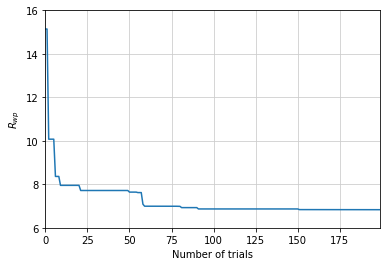

In [11]:
# Rwp plot
def rwp_plot():
    minvalues = [df.iloc[0]['Rwp']]
    for i in range(1, df.shape[0]):
        minvalues.append(min(minvalues[-1], df.iloc[i]['Rwp']))
    minvalues = pd.DataFrame(minvalues)
    
    minvalues.plot(legend=None)
    plt.ylim([6, 16])
    plt.grid(color='#cccccc')
    plt.ylabel('$R_{wp}$')
    plt.xlabel('Number of trials')
    plt.show()
    
rwp_plot()

GSAS-II binary directory: /opt/conda/GSASII/bindist


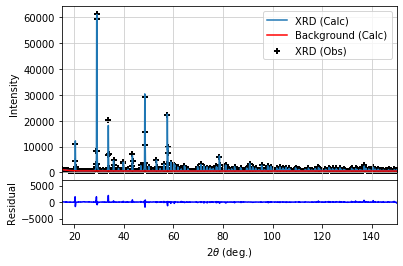

In [12]:
# Rietveld plot
def rietveld_plot():
    import GSASIIscriptable as G2sc

    gpx = G2sc.G2Project(
        '%s/%s_seed%s_trial_%s.gpx' % (WORK_DIR, STUDY_NAME, RANDOM_SEED, study.best_trial.number))

    hist1 = gpx.histograms()[0]
    phase0 = gpx.phases()[0]

    hist = hist1
    i = 5
    two_theta = hist.getdata("X")[::i]
    Yobs = hist.getdata("Yobs")[::i]
    Ycalc = hist.getdata("Ycalc")[::i]
    bg = hist.getdata("Background")[::i]
    residual = hist.getdata("Residual")[::i]

    fig = plt.figure()
    gs = GridSpec(5, 1, figure=fig)
    ax1 = fig.add_subplot(gs[:4, :])
    ax2 = fig.add_subplot(gs[4, :])
    fig.subplots_adjust(hspace=0)
    ax1.grid(color='#cccccc')

    ax1.scatter(two_theta, Yobs, marker='P', lw=0.0001, c='Black', label='XRD (Obs)')
    ax1.plot(two_theta, Ycalc, label='XRD (Calc)')
    ax1.plot(two_theta, bg, color='red', label='Background (Calc)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax2.plot(two_theta, residual, color='blue')
    plt.setp(ax1.get_xticklabels(), visible=False);
    ax2.set_ylim(-6600, 6600)
    plt.xlabel(r'$2\theta$ (deg.)')
    ax2.set_ylabel('Residual')
    ax1.set_xlim(15, 150)
    ax2.set_xlim(15, 150)
    plt.show()
    
rietveld_plot()